In [1]:
# to run the code partly i.e for bureau and previous data set seperatly use the switch partly_run
partly_run=True

## Imports
We are using a typical data science stack: <br>
numpy, pandas, sklearn, matplotlib, seaborn, LabelEncoder, os, sys

In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

#garbage collector
import gc 

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Set the style of plots
plt.style.use('fivethirtyeight')

# KFold
from sklearn.model_selection import KFold

# modeling 
import lightgbm as lgb

# utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

### Function for KDE Plots of Variable

In [3]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.ix[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.ix[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.ix[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.ix[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

### Function to Aggregate Numeric Data

In [4]:
def agg_numeric(df, parent_var, df_name):
    """
    Groups and aggregates the numeric values in a child dataframe
    by the parent variable.
    
    Parameters
    --------
        df (dataframe): 
            the child dataframe to calculate the statistics on
        parent_var (string): 
            the parent variable used for grouping and aggregating
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated by the `parent_var` for 
            all numeric columns. Each observation of the parent variable will have 
            one row in the dataframe with the parent variable as the index. 
            The columns are also renamed using the `df_name`. Columns with all duplicate
            values are removed. 
    
    """
    
    # Remove id variables other than grouping variable
    for col in df:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    # Only want the numeric variables
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[parent_var] = parent_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(parent_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    # Need to create new column names
    columns = []

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        if var != parent_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    # Remove the columns with all redundant values
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    
    return agg

### Function to Calculate Categorical Counts

In [5]:
def agg_categorical(df, parent_var, df_name):
    """
    Aggregates the categorical features in a child dataframe
    for each observation of the parent variable.
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    parent_var : string
        The variable by which to group and aggregate the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with aggregated statistics for each observation of the parent_var
        The columns are also renamed and columns with duplicate values are removed.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[parent_var] = df[parent_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    # Remove duplicate columns by values
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

### Function to Aggregate Stats at the Client Level

In [6]:
def aggregate_client(df, group_vars, df_names):
    """Aggregate a dataframe with data at the loan level 
    at the client level
    
    Args:
        df (dataframe): data at the loan level
        group_vars (list of two strings): grouping variables for the loan 
        and then the client (example ['SK_ID_PREV', 'SK_ID_CURR'])
        names (list of two strings): names to call the resulting columns
        (example ['cash', 'client'])
        
    Returns:
        df_client (dataframe): aggregated numeric stats at the client level. 
        Each client will have a single row with all the numeric data aggregated
    """
    
    # Aggregate the numeric columns
    df_agg = agg_numeric(df, parent_var = group_vars[0], df_name = df_names[0])
    
    # If there are categorical variables
    if any(df.dtypes == 'category'):
    
        # Count the categorical columns
        df_counts = agg_categorical(df, parent_var = group_vars[0], df_name = df_names[0])

        # Merge the numeric and categorical
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Merge to get the client id in dataframe
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])

        
    # No categorical variables
    else:
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        
        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])
        
    # Memory management
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

### Function to Convert Data Types

In [7]:
import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

### Function to Calculate Missing Values

In [8]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df, print_info = False):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        if print_info:
            # Print some summary information
            print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
                "There are " + str(mis_val_table_ren_columns.shape[0]) +
                  " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

### Function to Remove Missing Values

In [9]:
def remove_missing_columns(train, test, threshold = 90):
    # Calculate missing stats for train and test (remember to calculate a percent!)
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = 100 * train_miss[0] / len(train)
    
    test_miss = pd.DataFrame(test.isnull().sum())
    test_miss['percent'] = 100 * test_miss[0] / len(test)
    
    # list of missing columns for train and test
    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
    missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])
    
    # Combine the two lists together
    missing_columns = list(set(missing_train_columns + missing_test_columns))
    
    # Print information
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    
    # Drop the missing columns and return
    train = train.drop(columns = missing_columns)
    test = test.drop(columns = missing_columns)
    
    return train, test

## Function containing lightGBM implementation

In [10]:
# model
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    # to record eval results for plotting
    evals_result = {} 

    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', boosting_type='goss',class_weight = 'balanced', learning_rate = 0.05,reg_alpha = 0.1, reg_lambda = 0.1, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc', 
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

## Function containing lightGBM implementation after PCA

In [11]:
# model_pca
def model_pca(features,train_ids,labels,test_features,test_ids , n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    # to record eval results for plotting
    evals_result = {} 
    # No categorical indices to record
    cat_indices = 'auto'  
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', boosting_type='goss',class_weight = 'balanced', learning_rate = 0.05,reg_alpha = 0.1, reg_lambda = 0.1, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc', 
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, metrics

## plot_feature_importances

In [12]:
plt.style.use('fivethirtyeight')
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

# Feature Selection
# WOE and IV

In [13]:
# =============================================================================
# WOE and IV
# =============================================================================
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)


# ----------------------------------------------------------
<br><br><br>
## Read in Data 

First, we can list all the available data files. There are a total of 9 files: 1 main file for training (with target) 1 main file for testing (without the target), 1 example submission file, and 6 other files containing additional information about each loan. 

In [40]:
# Training data
train = pd.read_csv('./data/application_train.csv')
print('Training data shape: ', train.shape)
train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


So, The training data has 307511 observations (each one a separate loan) and 122 features (variables) including the `TARGET` (the label we want to predict).

In [263]:
#list of original feature
original_features = list(train.columns)
print('Original Number of Features: ', len(original_features))

Original Number of Features:  122


In [41]:
# Testing data features
test = pd.read_csv('./data/application_test.csv')
print('Testing data shape: ', test.shape)
test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


The test set is considerably smaller and lacks a `TARGET` column. 

# > Exploratory Data Analysis

## Examine the Distribution of the Target Column

In [265]:
train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

Text(0.5,0,'Target variable')

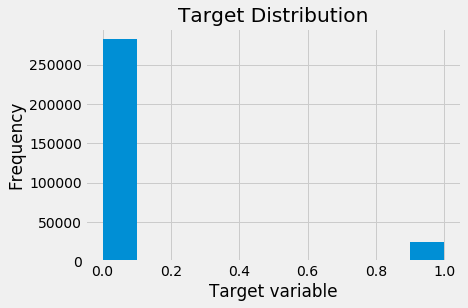

In [266]:
plt.style.use('fivethirtyeight')
train['TARGET'].astype(int).plot.hist(title = 'Target Distribution');
plt.xlabel('Target variable')

we see this is an `imbalanced class` problem. There are far more loans that were repaid on time than loans that were not repaid

In [267]:
#train = train[train['CODE_GENDER'] != 'XNA']

In [268]:
train.to_csv('./temp1.csv',index=False)
test.to_csv('./temp2.csv', index=False)
train=pd.read_csv('./temp1.csv')
test=pd.read_csv('./temp2.csv')

In [269]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.500,24700.500,351000.000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.019,-9461,-637,-3648.000,-2120,nan,1,1,0,1,1,0,Laborers,1.000,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083,0.263,0.139,0.025,0.037,0.972,0.619,0.014,0.000,...,0.025,0.037,0.972,0.624,0.014,0.000,0.069,0.083,0.125,0.037,0.021,0.019,0.000,0.000,reg oper account,block of flats,0.015,"Stone, brick",No,2.000,2.000,2.000,2.000,-1134.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,1.000
1,100003,0,Cash loans,F,N,N,0,270000.000,1293502.500,35698.500,1129500.000,Family,State servant,Higher education,Married,House / apartment,0.004,-16765,-1188,-1186.000,-291,nan,1,1,0,1,1,0,Core staff,2.000,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311,0.622,nan,0.096,0.053,0.985,0.796,0.060,0.080,...,0.097,0.053,0.985,0.799,0.061,0.080,0.035,0.292,0.333,0.013,0.079,0.056,0.004,0.010,reg oper account,block of flats,0.071,Block,No,1.000,0.000,1.000,0.000,-828.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
2,100004,0,Revolving loans,M,Y,Y,0,67500.000,135000.000,6750.000,135000.000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010,-19046,-225,-4260.000,-2531,26.000,1,1,1,1,1,0,Laborers,1.000,2,2,MONDAY,9,0,0,0,0,0,0,Government,nan,0.556,0.730,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,0.000,0.000,0.000,0.000,-815.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
3,100006,0,Cash loans,F,N,Y,0,135000.000,312682.500,29686.500,297000.000,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008,-19005,-3039,-9833.000,-2437,nan,1,1,0,1,0,0,Laborers,2.000,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,nan,0.650,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,2.000,0.000,2.000,0.000,-617.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,nan,nan,nan,nan,nan,nan
4,100007,0,Cash loans,M,N,Y,0,121500.000,513000.000,21865.500,513

In [270]:
live = [_f for _f in train.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]

In [271]:
live

['FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL']

In [50]:
#replace infinite values with nan
pd.options.mode.use_inf_as_na = True

In [273]:
# remove ambiguity
train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
train['NEW_LIVE_IND_SUM'] = train[live].sum(axis=1)

In [274]:
train['INCOME_PER_PERSON'] = train['AMT_INCOME_TOTAL'] / (1 + train['CNT_FAM_MEMBERS'])
train['ANNUITY_INCOME_RATIO'] = train['AMT_ANNUITY'] / (1 + train['AMT_INCOME_TOTAL'])

In [275]:
train['CHILDREN_RATIO'] = train['CNT_CHILDREN'] / (1 + train['CNT_FAM_MEMBERS'])

In [276]:
train['DAYS_EMPLOYED_PERC'] = train['DAYS_EMPLOYED'] / (1 + train['DAYS_BIRTH'])

In [277]:
train['NEW_CREDIT_TO_ANNUITY_RATIO'] = train['AMT_CREDIT'] / (1 + train['AMT_ANNUITY'])

In [278]:
train['NEW_CREDIT_TO_GOODS_RATIO'] = train['AMT_CREDIT'] / (1 + train['AMT_GOODS_PRICE'])

In [279]:
train['NEW_SOURCES_PROD'] = train['EXT_SOURCE_1'] * train['EXT_SOURCE_2'] * train['EXT_SOURCE_3']

In [280]:
train['NEW_SCORES_STD'] = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)

In [281]:
train['NEW_SCORES_STD'] = train['NEW_SCORES_STD'].fillna(train['NEW_SCORES_STD'].mean())

In [282]:
train['NEW_CAR_TO_EMPLOY_RATIO'] = train['OWN_CAR_AGE'] / ( 1 + train['DAYS_EMPLOYED'])

In [283]:
train['NEW_PHONE_TO_EMPLOY_RATIO'] = train['DAYS_LAST_PHONE_CHANGE'] / ( 1 + train['DAYS_EMPLOYED'])

In [284]:
#train['NEW_PHONE_TO_EMPLOY_RATIO'] = round(train['NEW_PHONE_TO_EMPLOY_RATIO'].astype(int)).apply(lambda x: [y if y <= 10 else np.nan for y in x])

In [285]:
#train[train['NEW_PHONE_TO_EMPLOY_RATIO']>10]['NEW_PHONE_TO_EMPLOY_RATIO'].astype(int)

In [286]:
test['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
test['NEW_LIVE_IND_SUM'] = test[live].sum(axis=1)
test['INCOME_PER_PERSON'] = test['AMT_INCOME_TOTAL'] / (1 + test['CNT_FAM_MEMBERS'])
test['ANNUITY_INCOME_RATIO'] = test['AMT_ANNUITY'] / (1 + test['AMT_INCOME_TOTAL'])
test['CHILDREN_RATIO'] = test['CNT_CHILDREN'] / (1 + test['CNT_FAM_MEMBERS'])
test['DAYS_EMPLOYED_PERC'] = test['DAYS_EMPLOYED'] / (1 + test['DAYS_BIRTH'])
test['NEW_CREDIT_TO_ANNUITY_RATIO'] = test['AMT_CREDIT'] / (1 + test['AMT_ANNUITY'])
test['NEW_CREDIT_TO_GOODS_RATIO'] = test['AMT_CREDIT'] / (1 + test['AMT_GOODS_PRICE'])
test['NEW_SOURCES_PROD'] = test['EXT_SOURCE_1'] * test['EXT_SOURCE_2'] * test['EXT_SOURCE_3']
test['NEW_SCORES_STD'] = test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
test['NEW_SCORES_STD'] = test['NEW_SCORES_STD'].fillna(test['NEW_SCORES_STD'].mean())
test['NEW_CAR_TO_EMPLOY_RATIO'] = test['OWN_CAR_AGE'] / ( 1 + test['DAYS_EMPLOYED'])
test['NEW_PHONE_TO_EMPLOY_RATIO'] = test['DAYS_LAST_PHONE_CHANGE'] / ( 1 + test['DAYS_EMPLOYED'])

In [287]:
#test=test[test.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)]

In [288]:
train.shape

(307511, 133)

In [289]:
test.shape

(48744, 132)

## Using WOE and IV

In [290]:
print(train.info())
print(train['TARGET'].value_counts())

train_labels = train['TARGET']
train_sk_id_curr = train['SK_ID_CURR']
#labels = np.array(train['TARGET'].astype(np.int32)).reshape((-1, 1))
labels = train['TARGET'].astype(np.int32)
labels
train['TARGET']=labels
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 133 entries, SK_ID_CURR to NEW_PHONE_TO_EMPLOY_RATIO
dtypes: float64(76), int64(41), object(16)
memory usage: 312.0+ MB
None
0    282686
1     24825
Name: TARGET, dtype: int64


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NEW_LIVE_IND_SUM,INCOME_PER_PERSON,ANNUITY_INCOME_RATIO,CHILDREN_RATIO,DAYS_EMPLOYED_PERC,NEW_CREDIT_TO_ANNUITY_RATIO,NEW_CREDIT_TO_GOODS_RATIO,NEW_SOURCES_PROD,NEW_SCORES_STD,NEW_CAR_TO_EMPLOY_RATIO,NEW_PHONE_TO_EMPLOY_RATIO
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.500,24700.500,351000.000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.019,-9461,-637.000,-3648.000,-2120,nan,1,1,0,1,1,0,Laborers,1.000,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083,0.263,0.139,0.025,0.037,0.972,0.619,0.014,0.000,...,0.019,0.000,0.000,reg oper account,block of flats,0.015,"Stone, brick",No,2.000,2.000,2.000,2.000,-1134.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,1.000,4,101250.000,0.122,0.000,0.067,16.460,1.158,0.003,0.092,nan,1.783
1,100003,0,Cash loans,F,N,N,0,270000.000,1293502.500,35698.500,1129500.000,Family,State servant,Higher education,Married,House / apartment,0.004,-16765,-1188.000,-1186.000,-291,nan,1,1,0,1,1,0,Core staff,2.000,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311,0.622,nan,0.096,0.053,0.985,0.796,0.060,0.080,...,0.056,0.004,0.010,reg oper account,block of flats,0.071,Block,No,1.000,0.000,1.000,0.000,-828.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000,4,90000.000,0.132,0.000,0.071,36.233,1.145,nan,0.220,nan,0.698
2,100004,0,Revolving loans,M,Y,Y,0,67500.000,135000.000,6750.000,135000.000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010,-19046,-225.000,-4260.000,-2531,26.000,1,1,1,1,1,0,Laborers,1.000,2,2,MONDAY,9,0,0,0,0,0,0,Government,nan,0.556,0.730,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,NaN,NaN,nan,NaN,NaN,0.000,0.000,0.000,0.000,-815.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000,5,33750.000,0.100,0.000,0.012,19.997,1.000,nan,0.123,-0.116,3.638
3,100006,0,Cash loans,F,N,Y,0,135000.000,312682.500,29686.500,297000.000,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008,-19005,-3039.000,-9833.000,-2437,nan,1,1,0,1,0,0,Laborers,2.000,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,nan,0.650,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,NaN,NaN,nan,NaN,NaN,2.000,0.000,2.000,0.000,-617.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,nan,nan,nan,nan,nan,nan,3,45000.000,0.220,0.000,0.160,10.532,1.0

In [291]:
test_sk_id_curr = test['SK_ID_CURR']
test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,...,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NEW_LIVE_IND_SUM,INCOME_PER_PERSON,ANNUITY_INCOME_RATIO,CHILDREN_RATIO,DAYS_EMPLOYED_PERC,NEW_CREDIT_TO_ANNUITY_RATIO,NEW_CREDIT_TO_GOODS_RATIO,NEW_SOURCES_PROD,NEW_SCORES_STD,NEW_CAR_TO_EMPLOY_RATIO,NEW_PHONE_TO_EMPLOY_RATIO
0,100001,Cash loans,F,N,Y,0,135000.000,568800.000,20560.500,450000.000,Unaccompanied,Working,Higher education,Married,House / apartment,0.019,-19241,-2329.000,-5170.000,-812,nan,1,1,0,1,0,1,NaN,2.000,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.753,0.790,0.160,0.066,0.059,0.973,nan,nan,nan,0.138,...,0.051,nan,nan,NaN,block of flats,0.039,"Stone, brick",No,0.000,0.000,0.000,0.000,-1740.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000,4,45000.000,0.152,0.000,0.121,27.663,1.264,0.095,0.354,nan,0.747
1,100005,Cash loans,M,N,Y,0,99000.000,222768.000,17370.000,180000.000,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.036,-18064,-4469.000,-9118.000,-1623,nan,1,1,0,1,0,0,Low-skill Laborers,2.000,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.565,0.292,0.433,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,NaN,NaN,nan,NaN,NaN,0.000,0.000,0.000,0.000,0.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,3.000,3,33000.000,0.175,0.000,0.247,12.824,1.238,0.071,0.137,nan,-0.000
2,100013,Cash loans,M,Y,Y,0,202500.000,663264.000,69777.000,630000.000,NaN,Working,Higher education,Married,House / apartment,0.019,-20038,-4458.000,-2175.000,-3503,5.000,1,1,0,1,0,0,Drivers,2.000,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,nan,0.700,0.611,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,NaN,NaN,nan,NaN,NaN,0.000,0.000,0.000,0.000,-856.000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,1.000,4.000,3,67500.000,0.345,0.000,0.222,9.505,1.053,nan,0.063,-0.001,0.192
3,100028,Cash loans,F,N,Y,2,315000.000,1575000.000,49018.500,1575000.000,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026,-13976,-1866.000,-2000.000,-4208,nan,1,1,0,1,1,0,Sales staff,4.000,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,0.526,0.510,0.613,0.305,0.197,0.997,0.959,0.117,0.320,0.276,...,0.374,0.039,0.082,reg oper account,block of flats,0.370,Panel,No,0.000,0.000,0.000,0.000,-1805.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,3.000,4,63000.000,0.156,0.400,0.134,32.130,1.000,0.164,0.055,nan,0.968
4,100038,Cas

In [292]:
#================================================
#20
max_bin = 20
force_bin = 3
final_iv, IV = data_vars(train,train.TARGET)
IV.shape

(132, 2)

In [293]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
IV[IV['IV'] > 0.02].sort_values('IV').tail()

,VAR_NAME,IV
25,DAYS_EMPLOYED,0.109
39,EXT_SOURCE_1,0.155
103,NEW_SOURCES_PROD,0.274
40,EXT_SOURCE_2,0.318
41,EXT_SOURCE_3,0.336


In [294]:
feature_selection_column=list(IV[IV['IV'] > 0.02]['VAR_NAME'])

In [295]:
len(feature_selection_column)

57

In [296]:
#IV[IV['IV'] > 0.01].sort_values('IV')

In [297]:
feature_drop_column=list(IV[IV['IV'] < 0.02]['VAR_NAME'])

In [298]:
len(feature_drop_column)

75

In [299]:
feature_drop_column

['AMT_ANNUITY',
 'AMT_CREDIT',
 'AMT_INCOME_TOTAL',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'ANNUITY_INCOME_RATIO',
 'CHILDREN_RATIO',
 'CNT_CHILDREN',
 'CNT_FAM_MEMBERS',
 'COMMONAREA_AVG',
 'COMMONAREA_MEDI',
 'COMMONAREA_MODE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'FLAG_CONT_MOBILE',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_EMAIL',
 'FLAG_MOBIL',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FLAG_PHONE',
 'FLAG_WORK_PHONE',
 'FLOORSMIN_AVG',
 'FLOORSMIN_MEDI',
 'FLOORSMIN_MOD

In [300]:
pd.options.display.max_columns=100
train[feature_drop_column].head()

,AMT_ANNUITY,AMT_CREDIT,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,ANNUITY_INCOME_RATIO,CHILDREN_RATIO,CNT_CHILDREN,CNT_FAM_MEMBERS,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,FLOORSMIN_AVG,FLOORSMIN_MEDI,FLOORSMIN_MODE,FONDKAPREMONT_MODE,HOUR_APPR_PROCESS_START,INCOME_PER_PERSON,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,NAME_CONTRACT_TYPE,NAME_HOUSING_TYPE,NAME_TYPE_SUITE,NEW_LIVE_IND_SUM,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,REGION_POPULATION_RELATIVE,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,SK_ID_CURR,WEEKDAY_APPR_PROCESS_START,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
0,24700.500,406597.500,202500.000,0.000,0.000,0.000,0.000,0.000,1.000,0.122,0.000,0,1.000,0.014,0.014,0.014,2.000,2.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,N,Y,1,0,0.125,0.125,0.125,reg oper account,10,101250.000,0.037,0.037,0.038,0,0,0.020,0.021,0.022,Cash loans,House / apartment,Unaccompanied,4,0.000,0.000,0.000,2.000,2.000,0.019,0,0,100002,WEDNESDAY,0.619,0.624,0.634
1,35698.500,1293502.500,270000.000,0.000,0.000,0.000,0.000,0.000,0.000,0.132,0.000,0,2.000,0.060,0.061,0.050,0.000,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,N,N,1,0,0.333,0.333,0.333,reg oper account,11,90000.000,0.013,0.013,0.013,0,0,0.077,0.079,0.079,Cash loans,House / apartment,Family,4,0.004,0.004,0.000,1.000,1.000,0.004,0,0,100003,MONDAY,0.796,0.799,0.804
2,6750.000,135000.000,67500.000,0.000,0.000,0.000,0.000,0.000,0.000,0.100,0.000,0,1.000,nan,nan,nan,0.000,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Y,Y,1,1,nan,nan,nan,NaN,9,33750.000,nan,nan,nan,0,0,nan,nan,nan,Revolving loans,House / apartment,Unaccompanied,5,nan,nan,nan,0.000,0.000,0.010,0,0,100004,MONDAY,nan,nan,nan
3,29686.500,312682.500,135000.000,nan,nan,nan,nan,nan,nan,0.220,0.000,0,2.000,nan,nan,nan,0.000,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,N,Y,0,0,nan,nan,nan,NaN,17,45000.000,nan,nan,nan,0,0,nan,nan,nan,Cash loans,House / apartment,Unaccompanied,3,nan,nan,nan,2.000,2.000,0.008,0,0,100006,WEDNESDAY,nan,nan,nan
4,21865.500,513000.000,121500.000,0.000,0.000,0.000,0.000,0.000,0.000,0.180,0.000,0,1.000,nan,nan,nan,0.000,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,N,Y,0,0,nan,nan,nan,NaN,11,60750.000,nan,nan,nan,1,0,nan,nan,nan,Cash loans,House / apartment,Unaccompanied,3,nan,nan,nan,0.000,0.000,0.029,0,0,100007,THURSDAY,nan,nan,nan


In [301]:
#living_space_info = ['COMMONAREA_AVG', 'COMMONAREA_MEDI', 'COMMONAREA_MODE', 'FLOORSMIN_AVG', 'FLOORSMIN_MEDI', 'FLOORSMIN_MODE', 'LANDAREA_AVG', 'LANDAREA_MEDI', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE', 'YEARS_BUILD_AVG', 'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE']

In [302]:
# selected columns
train = train.drop(columns=feature_drop_column)
test = test.drop(columns=feature_drop_column)

In [303]:
train.shape

(307511, 58)

### after removing the columns that has less importance we are left with only 58 columns

In [304]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
IV[IV['IV'] > 0.02].sort_values('IV')

,VAR_NAME,IV
102,NEW_SCORES_STD,0.020
16,BASEMENTAREA_MODE,0.020
98,NEW_CREDIT_TO_ANNUITY_RATIO,0.021
114,OWN_CAR_AGE,0.021
93,NAME_FAMILY_STATUS,0.022
108,NONLIVINGAREA_MEDI,0.022
107,NONLIVINGAREA_AVG,0.022
109,NONLIVINGAREA_MODE,0.022
15,BASEMENTAREA_MEDI,0.022
32,ELEVATORS_AVG,0.022


# Remove Collinear Variables

In [305]:
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train.corr().abs()
corr_matrix.head()

,TARGET,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_EMP_PHONE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,DAYS_EMPLOYED_PERC,NEW_CREDIT_TO_ANNUITY_RATIO,NEW_CREDIT_TO_GOODS_RATIO,NEW_SOURCES_PROD,NEW_SCORES_STD,NEW_CAR_TO_EMPLOY_RATIO,NEW_PHONE_TO_EMPLOY_RATIO
TARGET,1.000,0.040,0.078,0.075,0.042,0.051,0.038,0.046,0.059,0.061,0.044,0.051,0.155,0.160,0.179,0.029,0.023,0.010,0.034,0.019,0.044,0.033,0.014,0.027,0.020,0.009,0.032,0.017,0.043,0.031,0.013,0.029,0.022,0.010,0.034,0.019,0.044,0.033,0.013,0.033,0.055,0.044,0.068,0.032,0.069,0.189,0.044,0.023,0.001
AMT_GOODS_PRICE,0.040,1.000,0.053,0.093,0.012,0.009,0.104,0.063,0.104,0.112,0.027,0.020,0.176,0.139,0.048,0.065,0.044,0.007,0.084,0.019,0.109,0.077,0.042,0.058,0.036,0.006,0.078,0.013,0.106,0.069,0.036,0.063,0.042,0.007,0.082,0.018,0.108,0.076,0.040,0.078,0.076,0.075,0.070,0.632,0.116,0.167,0.037,0.031,0.003
DAYS_BIRTH,0.078,0.053,1.000,0.352,0.332,0.273,0.006,0.620,0.009,0.008,0.180,0.242,0.601,0.092,0.205,0.005,0.004,0.001,0.001,0.010,0.002,0.000,0.006,0.005,0.004,0.001,0.001,0.009,0.001,0.000,0.006,0.005,0.004,0.001,0.001,0.010,0.002,0.000,0.006,0.001,0.083,0.110,0.138,0.108,0.012,0.437,0.029,0.036,0.015
DAYS_EMPLOYED,0.075,0.093,0.352,1.000,0.172,0.090,0.030,0.002,0.011,0.009,0.114,0.129,0.253,0.093,0.130,0.003,0.008,0.002,0.007,0.014,0.005,0.001,0.005,0.003,0.008,0.002,0.006,0.015,0.004,0.000,0.004,0.004,0.008,0.003,0.006,0.014,0.005,0.001,0.005,0.002,0.142,0.047,0.955,0.089,0.013,0.222,0.038,0.126,0.164
DAYS_REGISTRATION,0.042,0.012,0.332,0.172,1.000,0.102,0.026,0.212,0.080,0.074,0.064,0.100,0.181,0.060,0.108,0.013,0.021,0.011,0.001,0.063,0.050,0.007,0.049,0.013,0.020,0.009,0.003,0.060,0.050,0.007,0.047,0.013,0.022,0.011,0.002,0.063,0.050,0.008,0.050,0.019,0.057,0.034,0.101,0.034,0.011,0.166,0.017,0.013,0.005


In [306]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()


,TARGET,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_EMP_PHONE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,DAYS_EMPLOYED_PERC,NEW_CREDIT_TO_ANNUITY_RATIO,NEW_CREDIT_TO_GOODS_RATIO,NEW_SOURCES_PROD,NEW_SCORES_STD,NEW_CAR_TO_EMPLOY_RATIO,NEW_PHONE_TO_EMPLOY_RATIO
TARGET,nan,0.040,0.078,0.075,0.042,0.051,0.038,0.046,0.059,0.061,0.044,0.051,0.155,0.160,0.179,0.029,0.023,0.010,0.034,0.019,0.044,0.033,0.014,0.027,0.020,0.009,0.032,0.017,0.043,0.031,0.013,0.029,0.022,0.010,0.034,0.019,0.044,0.033,0.013,0.033,0.055,0.044,0.068,0.032,0.069,0.189,0.044,0.023,0.001
AMT_GOODS_PRICE,nan,nan,0.053,0.093,0.012,0.009,0.104,0.063,0.104,0.112,0.027,0.020,0.176,0.139,0.048,0.065,0.044,0.007,0.084,0.019,0.109,0.077,0.042,0.058,0.036,0.006,0.078,0.013,0.106,0.069,0.036,0.063,0.042,0.007,0.082,0.018,0.108,0.076,0.040,0.078,0.076,0.075,0.070,0.632,0.116,0.167,0.037,0.031,0.003
DAYS_BIRTH,nan,nan,nan,0.352,0.332,0.273,0.006,0.620,0.009,0.008,0.180,0.242,0.601,0.092,0.205,0.005,0.004,0.001,0.001,0.010,0.002,0.000,0.006,0.005,0.004,0.001,0.001,0.009,0.001,0.000,0.006,0.005,0.004,0.001,0.001,0.010,0.002,0.000,0.006,0.001,0.083,0.110,0.138,0.108,0.012,0.437,0.029,0.036,0.015
DAYS_EMPLOYED,nan,nan,nan,nan,0.172,0.090,0.030,0.002,0.011,0.009,0.114,0.129,0.253,0.093,0.130,0.003,0.008,0.002,0.007,0.014,0.005,0.001,0.005,0.003,0.008,0.002,0.006,0.015,0.004,0.000,0.004,0.004,0.008,0.003,0.006,0.014,0.005,0.001,0.005,0.002,0.142,0.047,0.955,0.089,0.013,0.222,0.038,0.126,0.164
DAYS_REGISTRATION,nan,nan,nan,nan,nan,0.102,0.026,0.212,0.080,0.074,0.064,0.100,0.181,0.060,0.108,0.013,0.021,0.011,0.001,0.063,0.050,0.007,0.049,0.013,0.020,0.009,0.003,0.060,0.050,0.007,0.047,0.013,0.022,0.011,0.002,0.063,0.050,0.008,0.050,0.019,0.057,0.034,0.101,0.034,0.011,0.166,0.017,0.013,0.005


In [307]:
threshold = 0.7
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 21 columns to remove.


In [308]:
upper[to_drop].head()

,REGION_RATING_CLIENT_W_CITY,ELEVATORS_AVG,LIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,DAYS_EMPLOYED_PERC
TARGET,0.061,0.034,0.033,0.027,0.020,0.009,0.032,0.017,0.043,0.031,0.013,0.029,0.022,0.010,0.034,0.019,0.044,0.033,0.013,0.033,0.068
AMT_GOODS_PRICE,0.112,0.084,0.077,0.058,0.036,0.006,0.078,0.013,0.106,0.069,0.036,0.063,0.042,0.007,0.082,0.018,0.108,0.076,0.040,0.078,0.070
DAYS_BIRTH,0.008,0.001,0.000,0.005,0.004,0.001,0.001,0.009,0.001,0.000,0.006,0.005,0.004,0.001,0.001,0.010,0.002,0.000,0.006,0.001,0.138
DAYS_EMPLOYED,0.009,0.007,0.001,0.003,0.008,0.002,0.006,0.015,0.004,0.000,0.004,0.004,0.008,0.003,0.006,0.014,0.005,0.001,0.005,0.002,0.955
DAYS_REGISTRATION,0.074,0.001,0.007,0.013,0.020,0.009,0.003,0.060,0.050,0.007,0.047,0.013,0.022,0.011,0.002,0.063,0.050,0.008,0.050,0.019,0.101


In [309]:
to_drop

['REGION_RATING_CLIENT_W_CITY',
 'ELEVATORS_AVG',
 'LIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAREA_MEDI',
 'TOTALAREA_MODE',
 'DAYS_EMPLOYED_PERC']

In [310]:
train = train.drop(columns = to_drop)
test = test.drop(columns = to_drop)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 37)
Testing shape:  (48744, 36)


In [311]:
train.columns

Index(['TARGET', 'CODE_GENDER', 'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_EMP_PHONE', 'OCCUPATION_TYPE', 'REGION_RATING_CLIENT',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG',
       'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'NONLIVINGAREA_AVG', 'HOUSETYPE_MODE',
       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'DAYS_LAST_PHONE_CHANGE',
       'FLAG_DOCUMENT_3', 'NEW_CREDIT_TO_ANNUITY_RATIO',
       'NEW_CREDIT_TO_GOODS_RATIO', 'NEW_SOURCES_PROD', 'NEW_SCORES_STD',
       'NEW_CAR_TO_EMPLOY_RATIO', 'NEW_PHONE_TO_EMPLOY_RATIO'],
      dtype='object')

In [312]:
train_bkp=train.copy()
test_bkp=test.copy()

In [313]:
train.head()


,TARGET,CODE_GENDER,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_EMP_PHONE,OCCUPATION_TYPE,REGION_RATING_CLIENT,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,NONLIVINGAREA_AVG,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,NEW_CREDIT_TO_ANNUITY_RATIO,NEW_CREDIT_TO_GOODS_RATIO,NEW_SOURCES_PROD,NEW_SCORES_STD,NEW_CAR_TO_EMPLOY_RATIO,NEW_PHONE_TO_EMPLOY_RATIO
0,1,M,351000.000,Working,Secondary / secondary special,Single / not married,-9461,-637.000,-3648.000,-2120,nan,1,Laborers,2,0,0,Business Entity Type 3,0.083,0.263,0.139,0.025,0.037,0.972,0.069,0.083,0.000,block of flats,"Stone, brick",No,-1134.000,1,16.460,1.158,0.003,0.092,nan,1.783
1,0,F,1129500.000,State servant,Higher education,Married,-16765,-1188.000,-1186.000,-291,nan,1,Core staff,1,0,0,School,0.311,0.622,nan,0.096,0.053,0.985,0.035,0.292,0.010,block of flats,Block,No,-828.000,1,36.233,1.145,nan,0.220,nan,0.698
2,0,M,135000.000,Working,Secondary / secondary special,Single / not married,-19046,-225.000,-4260.000,-2531,26.000,1,Laborers,2,0,0,Government,nan,0.556,0.730,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,-815.000,0,19.997,1.000,nan,0.123,-0.116,3.638
3,0,F,297000.000,Working,Secondary / secondary special,Civil marriage,-19005,-3039.000,-9833.000,-2437,nan,1,Laborers,2,0,0,Business Entity Type 3,nan,0.650,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,-617.000,1,10.532,1.053,nan,0.151,nan,0.203
4,0,M,513000.000,Working,Secondary / secondary special,Single / not married,-19932,-3038.000,-4311.000,-3458,nan,1,Core staff,2,0,1,Religion,nan,0.323,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,-1106.000,0,23.461,1.000,nan,0.151,nan,0.364


In [314]:
(train['NEW_CAR_TO_EMPLOY_RATIO']).describe()

count   94413.000
mean       -0.016
std         0.089
min       -23.000
25%        -0.014
50%        -0.005
75%        -0.002
max        -0.000
Name: NEW_CAR_TO_EMPLOY_RATIO, dtype: float64

In [315]:
(train[['DAYS_BIRTH','DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE']]/-365).describe()

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE
count,307511.000,252137.000,307511.000,307511.000,307510.000
mean,43.937,6.532,13.661,8.203,2.638
std,11.956,6.406,9.652,4.135,2.265
min,20.518,-0.000,-0.000,-0.000,-0.000
25%,34.008,2.101,5.507,4.712,0.751
50%,43.151,4.515,12.340,8.915,2.074
75%,53.923,8.699,20.492,11.778,4.301
max,69.121,49.074,67.595,19.718,11.759


In [316]:
(train[['AMT_GOODS_PRICE','REGION_RATING_CLIENT','BASEMENTAREA_AVG', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG','YEARS_BEGINEXPLUATATION_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'NONLIVINGAREA_AVG','NEW_CREDIT_TO_ANNUITY_RATIO']]).describe()

,AMT_GOODS_PRICE,REGION_RATING_CLIENT,BASEMENTAREA_AVG,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,YEARS_BEGINEXPLUATATION_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,NONLIVINGAREA_AVG,NEW_CREDIT_TO_ANNUITY_RATIO
count,307233.000,307511.000,127568.000,134133.000,306851.000,246546.000,151450.000,157504.000,152683.000,154491.000,137829.000,307499.000
mean,538396.207,2.052,0.088,0.502,0.514,0.511,0.117,0.978,0.150,0.226,0.028,21.611
std,369446.461,0.509,0.082,0.211,0.191,0.195,0.108,0.059,0.100,0.145,0.070,7.824
min,40500.000,1.000,0.000,0.015,0.000,0.001,0.000,0.000,0.000,0.000,0.000,8.036
25%,238500.000,2.000,0.044,0.334,0.392,0.371,0.058,0.977,0.069,0.167,0.000,15.614
50%,450000.000,2.000,0.076,0.506,0.566,0.535,0.088,0.982,0.138,0.167,0.004,19.999
75%,679500.000,2.000,0.112,0.675,0.664,0.669,0.148,0.987,0.207,0.333,0.028,27.099
max,4050000.000,3.000,1.000,0.963,0.855,0.896,1.000,1.000,1.000,1.000,1.000,45.301


In [317]:
train['SK_ID_CURR']=train_sk_id_curr
test['SK_ID_CURR']=test_sk_id_curr

# previous_application data

In [318]:
previous = pd.read_csv('./data/previous_application.csv')
previous.sort_values('SK_ID_CURR').head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
201668,1369693,100001,Consumer loans,3951.000,24835.500,23787.000,2520.000,24835.500,FRIDAY,13,Y,1,0.104,nan,nan,XAP,Approved,-1740,Cash through the bank,XAP,Family,Refreshed,Mobile,POS,XNA,Country-wide,23,Connectivity,8.000,high,POS mobile with interest,365243.000,-1709.000,-1499.000,-1619.000,-1612.000,0.000
892077,1038818,100002,Consumer loans,9251.775,179055.000,179055.000,0.000,179055.000,SATURDAY,9,Y,1,0.000,nan,nan,XAP,Approved,-606,XNA,XAP,NaN,New,Vehicles,POS,XNA,Stone,500,Auto technology,24.000,low_normal,POS other with interest,365243.000,-565.000,125.000,-25.000,-17.000,0.000
575941,1810518,100003,Cash loans,98356.995,900000.000,1035882.000,nan,900000.000,FRIDAY,12,Y,1,nan,nan,nan,XNA,Approved,-746,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.000,low_normal,Cash X-Sell: low,365243.000,-716.000,-386.000,-536.000,-527.000,1.000
1021650,2636178,100003,Consumer loans,64567.665,337500.000,348637.500,0.000,337500.000,SUNDAY,17,Y,1,0.000,nan,nan,XAP,Approved,-828,Cash through the bank,XAP,Family,Refreshed,Furniture,POS,XNA,Stone,1400,Furniture,6.000,middle,POS industry with interest,365243.000,-797.000,-647.000,-647.000,-639.000,0.000
1223745,2396755,100003,Consumer loans,6737.310,68809.500,68053.500,6885.000,68809.500,SATURDAY,15,Y,1,0.100,nan,nan,XAP,Approved,-2341,Cash through the bank,XAP,Family,Refreshed,Consumer Electronics,POS,XNA,Country-wide,200,Consumer electronics,12.000,middle,POS household with interest,365243.000,-2310.000,-1980.000,-1980.000,-1976.000,1.000


In [319]:
previous.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

In [320]:
previous.groupby('CHANNEL_TYPE').sum()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
CHANNEL_TYPE,,,,,,,,,,,,,,,,,,,,,
AP+ (Cash loan),109906135932,15866951402,1007180229.960,16126450434.495,19238196825.495,0.000,16128700434.495,674514,56031,0.000,0.000,0.000,-31746861,1863929,1049804.000,9088154901.000,939151358.000,2687472681.000,4465800045.000,4619205650.000,16219.000
Car dealer,858474757,123253978,17098335.630,686767419.000,533975949.000,161787114.000,686767419.000,5634,452,105.401,0.000,0.000,-973904,1078612,23040.000,87292557.000,-512894.000,207472.000,3771158.000,4138258.000,34.000
Channel of corporate sales,11806972649,1707311969,145968526.620,3908422403.595,4132634188.095,0.000,3908422403.595,79457,6137,0.000,0.000,0.000,-2930069,-6150,201630.000,749364948.000,170173989.000,285069972.000,485042396.000,494553950.000,317.000
Contact center,142011475432,19798232237,1138578689.250,21988914677.865,25201677406.365,0.000,21988914677.865,931051,71066,0.000,0.000,0.000,-38567383,-67398,1288312.000,4878041690.000,494289139.000,3467931444.000,3530277326.000,4885003246.000,5626.000
Country-wide,943444256786,137698402134,4338363373.560,44124339047.448,45748701714.061,2527806270.420,44124339047.448,6568618,493260,36107.723,1029.134,4471.373,-624568999,405312603,5219441.000,138985822429.000,3767264399.000,6502986426.000,19490483731.000,21638523514.000,81817.000
Credit and cash offices,1392491296072,200498476781,10406283054.659,169453345652.010,196536731745.510,0.000,169487883152.010,8619443,717372,0.000,0.000,0.000,-385199772,-276599,9547269.000,86471751667.000,6436382520.000,17942915541.000,34478925988.000,35269773540.000,188754.000
Regional / Local,207056977001,30261256042,1207547788.050,12116442379.905,12239639241.660,744439790.745,12116779879.905,1365813,108332,7506.287,17.421,23.866,-105919962,39886157,1208621.000,33796388888.000,1118159073.000,1450541973.000,6043074627.000,6306392315.000,10954.000
Stone,404394808448,58962164637,2448391560.705,24273364833.720,23920630650.360,1752234119.055,24273364833.720,2606725,211664,17948.950,74.356,107.875,-281016561,76574394,2299824.000,67177397662.000,861943059.000,1334376621.000,7866691362.000,8540993193.000,27901.000


In [321]:
previous[previous['SK_ID_CURR']==271877]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.000,17145.000,0.000,17145.000,SATURDAY,15,Y,1,0.000,0.183,0.867,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.000,middle,POS mobile with interest,365243.000,-42.000,300.000,-42.000,-37.000,0.000
735737,1696966,271877,Consumer loans,68258.655,1800000.000,1754721.000,180000.000,1800000.000,SATURDAY,18,Y,1,0.101,nan,nan,XAP,Refused,-472,Cash through the bank,SCO,NaN,Repeater,Clothing and Accessories,POS,XNA,Regional / Local,55,Furniture,36.000,low_normal,POS industry with interest,nan,nan,nan,nan,nan,nan
1567518,2154916,271877,Consumer loans,12417.390,108400.500,119848.500,0.000,108400.500,SUNDAY,14,Y,1,0.000,nan,nan,XAP,Approved,-548,Cash through the bank,XAP,NaN,New,Furniture,POS,XNA,Stone,196,Furniture,12.000,middle,POS industry with interest,365243.000,-512.000,-182.000,-392.000,-387.000,0.000


In [322]:
# Calculate aggregate statistics for each numeric column
previous_agg_num = agg_numeric(previous, 'SK_ID_CURR', 'previous')
print('Previous aggregation shape: ', previous_agg_num.shape)
previous_agg_num.head()

Previous aggregation shape:  (338857, 84)


,previous_DAYS_DECISION_sum,previous_DAYS_DECISION_min,previous_DAYS_DECISION_mean,previous_DAYS_DECISION_max,previous_DAYS_FIRST_DUE_sum,previous_DAYS_FIRST_DUE_min,previous_DAYS_FIRST_DUE_mean,previous_DAYS_FIRST_DUE_max,previous_DAYS_LAST_DUE_sum,previous_DAYS_LAST_DUE_min,previous_DAYS_LAST_DUE_mean,previous_DAYS_LAST_DUE_max,previous_DAYS_TERMINATION_sum,previous_DAYS_TERMINATION_min,previous_DAYS_TERMINATION_mean,previous_DAYS_TERMINATION_max,previous_DAYS_LAST_DUE_1ST_VERSION_sum,previous_DAYS_LAST_DUE_1ST_VERSION_min,previous_DAYS_LAST_DUE_1ST_VERSION_mean,previous_DAYS_LAST_DUE_1ST_VERSION_max,previous_RATE_INTEREST_PRIMARY_sum,previous_RATE_INTEREST_PRIVILEGED_sum,previous_RATE_INTEREST_PRIMARY_count,previous_NFLAG_INSURED_ON_APPROVAL_min,previous_NFLAG_INSURED_ON_APPROVAL_mean,previous_NFLAG_INSURED_ON_APPROVAL_max,previous_NFLAG_INSURED_ON_APPROVAL_sum,previous_RATE_DOWN_PAYMENT_min,previous_RATE_DOWN_PAYMENT_mean,previous_RATE_DOWN_PAYMENT_max,previous_RATE_DOWN_PAYMENT_sum,previous_NFLAG_LAST_APPL_IN_DAY_min,previous_NFLAG_LAST_APPL_IN_DAY_mean,previous_NFLAG_LAST_APPL_IN_DAY_max,previous_AMT_DOWN_PAYMENT_count,previous_DAYS_FIRST_DRAWING_count,previous_AMT_GOODS_PRICE_count,previous_AMT_ANNUITY_count,previous_CNT_PAYMENT_count,previous_NFLAG_LAST_APPL_IN_DAY_sum,previous_AMT_CREDIT_count,previous_AMT_APPLICATION_count,previous_CNT_PAYMENT_min,previous_CNT_PAYMENT_mean,previous_CNT_PAYMENT_max,previous_CNT_PAYMENT_sum,previous_HOUR_APPR_PROCESS_START_min,previous_HOUR_APPR_PROCESS_START_mean,previous_HOUR_APPR_PROCESS_START_max,previous_HOUR_APPR_PROCESS_START_sum,previous_SELLERPLACE_AREA_min,previous_SELLERPLACE_AREA_mean,previous_SELLERPLACE_AREA_max,previous_SELLERPLACE_AREA_sum,previous_AMT_DOWN_PAYMENT_min,previous_AMT_DOWN_PAYMENT_mean,previous_AMT_DOWN_PAYMENT_max,previous_AMT_DOWN_PAYMENT_sum,previous_AMT_ANNUITY_min,previous_AMT_ANNUITY_mean,previous_AMT_ANNUITY_max,previous_AMT_ANNUITY_sum,previous_AMT_CREDIT_min,previous_AMT_CREDIT_mean,previous_AMT_CREDIT_max,previous_AMT_CREDIT_sum,previous_AMT_APPLICATION_min,previous_AMT_GOODS_PRICE_min,previous_AMT_APPLICATION_mean,previous_AMT_GOODS_PRICE_mean,previous_AMT_APPLICATION_max,previous_AMT_GOODS_PRICE_max,previous_AMT_GOODS_PRICE_sum,previous_AMT_APPLICATION_sum,previous_DAYS_FIRST_DRAWING_min,previous_DAYS_FIRST_DRAWING_mean,previous_DAYS_FIRST_DRAWING_max,previous_DAYS_FIRST_DRAWING_sum,previous_RATE_INTEREST_PRIMARY_min,previous_RATE_INTEREST_PRIMARY_mean,previous_RATE_INTEREST_PRIMARY_max,previous_RATE_INTEREST_PRIVILEGED_min,previous_RATE_INTEREST_PRIVILEGED_mean,previous_RATE_INTEREST_PRIVILEGED_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,-1740,-1740,-1740.000,-1740,-1709.000,-1709.000,-1709.000,-1709.000,-1619.000,-1619.000,-1619.000,-1619.000,-1612.000,-1612.000,-1612.000,-1612.000,-1499.000,-1499.000,-1499.000,-1499.000,0.000,0.000,0,0.000,0.000,0.000,0.000,0.104,0.104,0.104,0.104,1,1.000,1,1,1,1,1,1,1,1,1,8.000,8.000,8.000,8.000,13,13.000,13,13,23,23.000,23,23,2520.000,2520.000,2520.000,2520.000,3951.000,3951.000,3951.000,3951.000,23787.000,23787.000,23787.000,23787.000,24835.500,24835.500,24835.500,24835.500,24835.500,24835.500,24835.500,24835.500,365243.000,365243.000,365243.000,365243.000,nan,nan,nan,nan,nan,nan
100002,-606,-606,-606.000,-606,-565.000,-565.000,-565.000,-565.000,-25.000,-25.000,-25.000,-25.000,-17.000,-17.000,-17.000,-17.000,125.000,125.000,125.000,125.000,0.000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,1.000,1,1,1,1,1,1,1,1,1,24.000,24.000,24.000,24.000,9,9.000,9,9,500,500.000,500,500,0.000,0.000,0.000,0.000,9251.775,9251.775,9251.775,9251.775,179055.000,179055.000,179055.000,179055.000,179055.000,179055.000,179055.000,179055.000,179055.000,179055.000,179055.000,179055.000,365243.000,365243.000,365243.000,365243.000,nan,nan,nan,nan,nan,nan
100003,-3915,-2341,-1305.000,-746,-3823.000,-2310.000,-1274.333,-716.000,-3163.000,-1980.000,-1054.333,-53

In [323]:
previous_agg_num.columns

Index(['previous_DAYS_DECISION_sum', 'previous_DAYS_DECISION_min',
       'previous_DAYS_DECISION_mean', 'previous_DAYS_DECISION_max',
       'previous_DAYS_FIRST_DUE_sum', 'previous_DAYS_FIRST_DUE_min',
       'previous_DAYS_FIRST_DUE_mean', 'previous_DAYS_FIRST_DUE_max',
       'previous_DAYS_LAST_DUE_sum', 'previous_DAYS_LAST_DUE_min',
       'previous_DAYS_LAST_DUE_mean', 'previous_DAYS_LAST_DUE_max',
       'previous_DAYS_TERMINATION_sum', 'previous_DAYS_TERMINATION_min',
       'previous_DAYS_TERMINATION_mean', 'previous_DAYS_TERMINATION_max',
       'previous_DAYS_LAST_DUE_1ST_VERSION_sum',
       'previous_DAYS_LAST_DUE_1ST_VERSION_min',
       'previous_DAYS_LAST_DUE_1ST_VERSION_mean',
       'previous_DAYS_LAST_DUE_1ST_VERSION_max',
       'previous_RATE_INTEREST_PRIMARY_sum',
       'previous_RATE_INTEREST_PRIVILEGED_sum',
       'previous_RATE_INTEREST_PRIMARY_count',
       'previous_NFLAG_INSURED_ON_APPROVAL_min',
       'previous_NFLAG_INSURED_ON_APPROVAL_mean',
       '

In [324]:
# Calculate value counts for each categorical column
previous_agg_cat = agg_categorical(previous, 'SK_ID_CURR', 'previous')
print('Previous Categorical shape: ', previous_agg_cat.shape)
previous_agg_cat.head()

Previous Categorical shape:  (338857, 285)


,previous_NAME_GOODS_CATEGORY_Animals_mean,previous_NAME_GOODS_CATEGORY_Animals_sum,previous_NAME_GOODS_CATEGORY_House Construction_mean,previous_NAME_GOODS_CATEGORY_House Construction_sum,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_mean,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_sum,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_mean,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_sum,previous_NAME_CASH_LOAN_PURPOSE_Hobby_mean,previous_NAME_CASH_LOAN_PURPOSE_Hobby_sum,previous_NAME_GOODS_CATEGORY_Education_mean,previous_NAME_GOODS_CATEGORY_Education_sum,previous_NAME_GOODS_CATEGORY_Additional Service_mean,previous_NAME_GOODS_CATEGORY_Additional Service_sum,previous_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_mean,previous_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_sum,previous_NAME_CASH_LOAN_PURPOSE_Buying a garage_mean,previous_NAME_CASH_LOAN_PURPOSE_Buying a garage_sum,previous_NAME_GOODS_CATEGORY_Insurance_mean,previous_NAME_GOODS_CATEGORY_Insurance_sum,previous_NAME_CASH_LOAN_PURPOSE_Business development_mean,previous_NAME_CASH_LOAN_PURPOSE_Business development_sum,previous_NAME_GOODS_CATEGORY_Fitness_mean,previous_NAME_GOODS_CATEGORY_Fitness_sum,previous_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_mean,previous_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_sum,previous_NAME_SELLER_INDUSTRY_MLM partners_mean,previous_NAME_SELLER_INDUSTRY_MLM partners_sum,previous_NAME_GOODS_CATEGORY_Direct Sales_mean,previous_NAME_GOODS_CATEGORY_Direct Sales_sum,previous_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_mean,previous_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_sum,previous_NAME_CASH_LOAN_PURPOSE_Journey_mean,previous_NAME_CASH_LOAN_PURPOSE_Journey_sum,previous_NAME_CASH_LOAN_PURPOSE_Furniture_mean,previous_NAME_CASH_LOAN_PURPOSE_Furniture_sum,previous_NAME_GOODS_CATEGORY_Weapon_mean,previous_NAME_GOODS_CATEGORY_Weapon_sum,previous_CODE_REJECT_REASON_SYSTEM_mean,previous_CODE_REJECT_REASON_SYSTEM_sum,previous_NAME_CONTRACT_TYPE_XNA_mean,previous_NAME_CONTRACT_TYPE_XNA_sum,previous_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_mean,previous_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_sum,previous_NAME_GOODS_CATEGORY_Medicine_mean,previous_NAME_GOODS_CATEGORY_Medicine_sum,previous_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_mean,previous_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_sum,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,previous_NAME_GOODS_CATEGORY_Sport and Leisure_sum,...,previous_NAME_YIELD_GROUP_middle_sum,previous_NAME_SELLER_INDUSTRY_Auto technology_mean,previous_NAME_GOODS_CATEGORY_Vehicles_mean,previous_NAME_SELLER_INDUSTRY_Auto technology_sum,previous_NAME_GOODS_CATEGORY_Vehicles_sum,previous_PRODUCT_COMBINATION_POS other with interest_mean,previous_PRODUCT_COMBINATION_POS other with interest_sum,previous_NAME_CLIENT_TYPE_New_mean,previous_NAME_CLIENT_TYPE_New_sum,previous_CHANNEL_TYPE_Stone_mean,previous_WEEKDAY_APPR_PROCESS_START_SATURDAY_mean,previous_NAME_YIELD_GROUP_low_normal_mean,previous_NAME_PAYMENT_TYPE_XNA_mean,previous_CHANNEL_TYPE_Stone_sum,previous_WEEKDAY_APPR_PROCESS_START_SATURDAY_sum,previous_NAME_YIELD_GROUP_low_normal_sum,previous_NAME_PAYMENT_TYPE_XNA_sum,previous_PRODUCT_COMBINATION_POS mobile with interest_mean,previous_NAME_YIELD_GROUP_high_mean,previous_PRODUCT_COMBINATION_POS mobile with interest_sum,previous_NAME_YIELD_GROUP_high_sum,previous_NAME_GOODS_CATEGORY_Mobile_mean,previous_NAME_SELLER_INDUSTRY_Connectivity_mean,previous_NAME_GOODS_CATEGORY_Mobile_sum,previous_NAME_SELLER_INDUSTRY_Connectivity_sum,previous_CHANNEL_TYPE_Country-wide_mean,previous_WEEKDAY_APPR_PROCESS_START_FRIDAY_mean,previous_NAME_CLIENT_TYPE_Refreshed_mean,previous_NAME_TYPE_SUITE_Family_mean,previous_NAME_PAYMENT_TYPE_Cash through the bank_mean,previous_CHANNEL_TYPE_Country-wide_sum,previous_WEEKDAY_APPR_PROCESS_START_FRIDAY_sum,previous_NAME_CLIENT_TYPE_Refreshed_sum,previous_NAME_T

In [325]:
# Merge in the previous information
train_prev = train.merge(previous_agg_num, on = 'SK_ID_CURR', how = 'left')
train_prev = train_prev.merge(previous_agg_cat, on ='SK_ID_CURR', how = 'left')

test_prev = test.merge(previous_agg_num, on = 'SK_ID_CURR', how = 'left')
test_prev = test_prev.merge(previous_agg_cat, on ='SK_ID_CURR', how = 'left')

In [326]:
train_prev.shape

(307511, 407)

In [327]:
test_prev.shape

(48744, 406)

In [328]:
train_prev['NEW_PREV_CREDIT_TO_ANNUITY_RATIO'] = train_prev['previous_AMT_CREDIT_sum'] / (1 + train_prev['previous_AMT_ANNUITY_sum'])
train_prev['NEW_PREV_CREDIT_TO_GOODS_RATIO'] = train_prev['previous_AMT_CREDIT_sum'] / (1 + train_prev['previous_AMT_GOODS_PRICE_sum'])

test_prev['NEW_PREV_CREDIT_TO_ANNUITY_RATIO'] = test_prev['previous_AMT_CREDIT_sum'] / (1 + test_prev['previous_AMT_ANNUITY_sum'])
test_prev['NEW_PREV_CREDIT_TO_GOODS_RATIO'] = test_prev['previous_AMT_CREDIT_sum'] / (1 + test_prev['previous_AMT_GOODS_PRICE_sum'])

In [329]:
train_prev['previous_Approved_To_Rejected_Ratio']=train_prev['previous_NAME_CONTRACT_STATUS_Approved_sum']/(train_prev['previous_NAME_CONTRACT_STATUS_Refused_sum']+ train_prev['previous_NAME_CONTRACT_STATUS_Canceled_sum']+ train_prev['previous_NAME_CONTRACT_STATUS_Unused offer_sum'])
test_prev['previous_Approved_To_Rejected_Ratio']=test_prev['previous_NAME_CONTRACT_STATUS_Approved_sum']/(test_prev['previous_NAME_CONTRACT_STATUS_Refused_sum']+ test_prev['previous_NAME_CONTRACT_STATUS_Canceled_sum']+ test_prev['previous_NAME_CONTRACT_STATUS_Unused offer_sum'])

In [330]:
train_prev.head()

,TARGET,CODE_GENDER,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_EMP_PHONE,OCCUPATION_TYPE,REGION_RATING_CLIENT,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,NONLIVINGAREA_AVG,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,NEW_CREDIT_TO_ANNUITY_RATIO,NEW_CREDIT_TO_GOODS_RATIO,NEW_SOURCES_PROD,NEW_SCORES_STD,NEW_CAR_TO_EMPLOY_RATIO,NEW_PHONE_TO_EMPLOY_RATIO,SK_ID_CURR,previous_DAYS_DECISION_sum,previous_DAYS_DECISION_min,previous_DAYS_DECISION_mean,previous_DAYS_DECISION_max,previous_DAYS_FIRST_DUE_sum,previous_DAYS_FIRST_DUE_min,previous_DAYS_FIRST_DUE_mean,previous_DAYS_FIRST_DUE_max,previous_DAYS_LAST_DUE_sum,previous_DAYS_LAST_DUE_min,previous_DAYS_LAST_DUE_mean,previous_DAYS_LAST_DUE_max,...,previous_NAME_SELLER_INDUSTRY_Auto technology_sum,previous_NAME_GOODS_CATEGORY_Vehicles_sum,previous_PRODUCT_COMBINATION_POS other with interest_mean,previous_PRODUCT_COMBINATION_POS other with interest_sum,previous_NAME_CLIENT_TYPE_New_mean,previous_NAME_CLIENT_TYPE_New_sum,previous_CHANNEL_TYPE_Stone_mean,previous_WEEKDAY_APPR_PROCESS_START_SATURDAY_mean,previous_NAME_YIELD_GROUP_low_normal_mean,previous_NAME_PAYMENT_TYPE_XNA_mean,previous_CHANNEL_TYPE_Stone_sum,previous_WEEKDAY_APPR_PROCESS_START_SATURDAY_sum,previous_NAME_YIELD_GROUP_low_normal_sum,previous_NAME_PAYMENT_TYPE_XNA_sum,previous_PRODUCT_COMBINATION_POS mobile with interest_mean,previous_NAME_YIELD_GROUP_high_mean,previous_PRODUCT_COMBINATION_POS mobile with interest_sum,previous_NAME_YIELD_GROUP_high_sum,previous_NAME_GOODS_CATEGORY_Mobile_mean,previous_NAME_SELLER_INDUSTRY_Connectivity_mean,previous_NAME_GOODS_CATEGORY_Mobile_sum,previous_NAME_SELLER_INDUSTRY_Connectivity_sum,previous_CHANNEL_TYPE_Country-wide_mean,previous_WEEKDAY_APPR_PROCESS_START_FRIDAY_mean,previous_NAME_CLIENT_TYPE_Refreshed_mean,previous_NAME_TYPE_SUITE_Family_mean,previous_NAME_PAYMENT_TYPE_Cash through the bank_mean,previous_CHANNEL_TYPE_Country-wide_sum,previous_WEEKDAY_APPR_PROCESS_START_FRIDAY_sum,previous_NAME_CLIENT_TYPE_Refreshed_sum,previous_NAME_TYPE_SUITE_Family_sum,previous_NAME_PAYMENT_TYPE_Cash through the bank_sum,previous_NAME_PORTFOLIO_POS_mean,previous_NAME_CONTRACT_TYPE_Consumer loans_mean,previous_NAME_CASH_LOAN_PURPOSE_XAP_mean,previous_NAME_PRODUCT_TYPE_XNA_mean,previous_NAME_CONTRACT_STATUS_Approved_mean,previous_CODE_REJECT_REASON_XAP_mean,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_mean,previous_NAME_PORTFOLIO_POS_sum,previous_NAME_CONTRACT_TYPE_Consumer loans_sum,previous_NAME_CASH_LOAN_PURPOSE_XAP_sum,previous_NAME_PRODUCT_TYPE_XNA_sum,previous_NAME_CONTRACT_STATUS_Approved_sum,previous_CODE_REJECT_REASON_XAP_sum,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_sum,previous_NAME_CONTRACT_TYPE_Cash loans_count,NEW_PREV_CREDIT_TO_ANNUITY_RATIO,NEW_PREV_CREDIT_TO_GOODS_RATIO,previous_Approved_To_Rejected_Ratio
0,1,M,351000.000,Working,Secondary / secondary special,Single / not married,-9461,-637.000,-3648.000,-2120,nan,1,Laborers,2,0,0,Business Entity Type 3,0.083,0.263,0.139,0.025,0.037,0.972,0.069,0.083,0.000,block of flats,"Stone, brick",No,-1134.000,1,16.460,1.158,0.003,0.092,nan,1.783,100002,-606.000,-606.000,-606.000,-606.000,-565.000,-565.000,-565.000,-565.000,-25.000,-25.000,-25.000,-25.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,19.351,1.000,inf
1,0,F,1129500.000,State servant,Higher education,Married,-16765,-1188.000,-1186.000,-291,nan,1,Core staff,1,0,0,School,0.311,0.622,nan,0.096,0.053,0.985,0.035,0.292,0.010,block of flats,Block,No,-828.000,1

In [331]:
# WOE & IV

In [332]:
#================================================
#20
max_bin = 20
force_bin = 3
final_iv, IV = data_vars(train_prev,train_prev.TARGET)
IV.shape

(409, 2)

In [333]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
IV[IV['IV'] > 0.02].sort_values('IV').tail()

,VAR_NAME,IV
5,DAYS_EMPLOYED,0.109
11,EXT_SOURCE_1,0.155
28,NEW_SOURCES_PROD,0.274
12,EXT_SOURCE_2,0.318
13,EXT_SOURCE_3,0.336


In [334]:
feature_selection_column=list(IV[IV['IV'] > 0.02]['VAR_NAME'])

In [335]:
len(feature_selection_column)

70

In [336]:
feature_selection_column

['AMT_GOODS_PRICE',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'CODE_GENDER',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_REGISTRATION',
 'EMERGENCYSTATE_MODE',
 'ENTRANCES_AVG',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FLAG_DOCUMENT_3',
 'FLAG_EMP_PHONE',
 'FLOORSMAX_AVG',
 'HOUSETYPE_MODE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_INCOME_TYPE',
 'NEW_CAR_TO_EMPLOY_RATIO',
 'NEW_CREDIT_TO_ANNUITY_RATIO',
 'NEW_CREDIT_TO_GOODS_RATIO',
 'NEW_PHONE_TO_EMPLOY_RATIO',
 'NEW_PREV_CREDIT_TO_GOODS_RATIO',
 'NEW_SCORES_STD',
 'NEW_SOURCES_PROD',
 'NONLIVINGAREA_AVG',
 'OCCUPATION_TYPE',
 'ORGANIZATION_TYPE',
 'OWN_CAR_AGE',
 'REGION_RATING_CLIENT',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'WALLSMATERIAL_MODE',
 'YEARS_BEGINEXPLUATATION_AVG',
 'previous_AMT_ANNUITY_mean',
 'previous_AMT_ANNUITY_min',
 'previous_AMT_DOWN_PAYMENT_max',
 'previous_AMT_DOWN_PAYMENT_mean',
 'previous_AMT_DOWN_PAYMENT_sum',
 'previous_App

In [337]:
feature_drop_column=list(IV[IV['IV'] < 0.01]['VAR_NAME'])

In [338]:
len(feature_drop_column)

290

In [339]:
feature_drop_column

['SK_ID_CURR',
 'previous_AMT_ANNUITY_count',
 'previous_AMT_ANNUITY_sum',
 'previous_AMT_APPLICATION_count',
 'previous_AMT_APPLICATION_max',
 'previous_AMT_APPLICATION_min',
 'previous_AMT_APPLICATION_sum',
 'previous_AMT_CREDIT_count',
 'previous_AMT_CREDIT_max',
 'previous_AMT_CREDIT_sum',
 'previous_AMT_DOWN_PAYMENT_min',
 'previous_AMT_GOODS_PRICE_count',
 'previous_AMT_GOODS_PRICE_max',
 'previous_AMT_GOODS_PRICE_mean',
 'previous_AMT_GOODS_PRICE_sum',
 'previous_CHANNEL_TYPE_AP+ (Cash loan)_mean',
 'previous_CHANNEL_TYPE_Car dealer_mean',
 'previous_CHANNEL_TYPE_Car dealer_sum',
 'previous_CHANNEL_TYPE_Channel of corporate sales_mean',
 'previous_CHANNEL_TYPE_Channel of corporate sales_sum',
 'previous_CHANNEL_TYPE_Contact center_mean',
 'previous_CHANNEL_TYPE_Country-wide_mean',
 'previous_CHANNEL_TYPE_Country-wide_sum',
 'previous_CHANNEL_TYPE_Credit and cash offices_mean',
 'previous_CHANNEL_TYPE_Credit and cash offices_sum',
 'previous_CHANNEL_TYPE_Regional / Local_mean',
 

In [340]:
# selected columns
train_prev = train_prev.drop(columns=feature_drop_column)
test_prev = test_prev.drop(columns=feature_drop_column)

In [341]:
print(train_prev.shape)
test_prev.shape

(307511, 120)


(48744, 119)

# Remove Collinear Variables

In [342]:
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train_prev.corr().abs()
corr_matrix.head()

,TARGET,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_EMP_PHONE,REGION_RATING_CLIENT,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,NONLIVINGAREA_AVG,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,NEW_CREDIT_TO_ANNUITY_RATIO,NEW_CREDIT_TO_GOODS_RATIO,NEW_SOURCES_PROD,NEW_SCORES_STD,NEW_CAR_TO_EMPLOY_RATIO,NEW_PHONE_TO_EMPLOY_RATIO,previous_DAYS_DECISION_sum,previous_DAYS_DECISION_min,previous_DAYS_DECISION_mean,previous_DAYS_DECISION_max,previous_DAYS_FIRST_DUE_sum,previous_DAYS_FIRST_DUE_min,previous_DAYS_FIRST_DUE_mean,previous_DAYS_LAST_DUE_sum,previous_DAYS_LAST_DUE_min,previous_DAYS_LAST_DUE_mean,previous_DAYS_TERMINATION_sum,previous_DAYS_TERMINATION_min,previous_DAYS_TERMINATION_mean,previous_DAYS_LAST_DUE_1ST_VERSION_sum,previous_DAYS_LAST_DUE_1ST_VERSION_min,previous_DAYS_LAST_DUE_1ST_VERSION_mean,previous_RATE_DOWN_PAYMENT_mean,previous_RATE_DOWN_PAYMENT_max,previous_RATE_DOWN_PAYMENT_sum,previous_AMT_DOWN_PAYMENT_count,previous_DAYS_FIRST_DRAWING_count,previous_CNT_PAYMENT_mean,...,previous_AMT_ANNUITY_mean,previous_AMT_ANNUITY_max,previous_AMT_CREDIT_min,previous_AMT_CREDIT_mean,previous_AMT_GOODS_PRICE_min,previous_AMT_APPLICATION_mean,previous_DAYS_FIRST_DRAWING_min,previous_DAYS_FIRST_DRAWING_sum,previous_CODE_REJECT_REASON_SCOFR_sum,previous_NAME_CASH_LOAN_PURPOSE_Repairs_sum,previous_CODE_REJECT_REASON_HC_sum,previous_CHANNEL_TYPE_Contact center_sum,previous_PRODUCT_COMBINATION_Cash Street: high_sum,previous_CHANNEL_TYPE_AP+ (Cash loan)_sum,previous_NAME_PRODUCT_TYPE_walk-in_sum,previous_PRODUCT_COMBINATION_Card Street_sum,previous_PRODUCT_COMBINATION_Cash X-Sell: high_sum,previous_CODE_REJECT_REASON_LIMIT_sum,previous_NAME_CONTRACT_STATUS_Refused_sum,previous_NAME_PORTFOLIO_Cards_sum,previous_NAME_CONTRACT_TYPE_Revolving loans_sum,previous_NAME_YIELD_GROUP_XNA_mean,previous_PRODUCT_COMBINATION_Cash_sum,previous_NAME_PORTFOLIO_XNA_sum,previous_NAME_YIELD_GROUP_XNA_sum,previous_NAME_SELLER_INDUSTRY_Consumer electronics_mean,previous_NAME_SELLER_INDUSTRY_XNA_mean,previous_NAME_GOODS_CATEGORY_XNA_mean,previous_PRODUCT_COMBINATION_POS industry with interest_sum,previous_PRODUCT_COMBINATION_Cash X-Sell: low_sum,previous_NAME_SELLER_INDUSTRY_XNA_sum,previous_NAME_GOODS_CATEGORY_XNA_sum,previous_NAME_CLIENT_TYPE_New_sum,previous_NAME_YIELD_GROUP_low_normal_mean,previous_NAME_PAYMENT_TYPE_XNA_mean,previous_NAME_YIELD_GROUP_low_normal_sum,previous_NAME_PAYMENT_TYPE_XNA_sum,previous_NAME_YIELD_GROUP_high_mean,previous_NAME_YIELD_GROUP_high_sum,previous_NAME_PAYMENT_TYPE_Cash through the bank_mean,previous_NAME_PORTFOLIO_POS_mean,previous_NAME_CONTRACT_TYPE_Consumer loans_mean,previous_NAME_PRODUCT_TYPE_XNA_mean,previous_NAME_CONTRACT_STATUS_Approved_mean,previous_NAME_PORTFOLIO_POS_sum,previous_NAME_CONTRACT_TYPE_Consumer loans_sum,previous_NAME_CONTRACT_STATUS_Approved_sum,NEW_PREV_CREDIT_TO_ANNUITY_RATIO,NEW_PREV_CREDIT_TO_GOODS_RATIO,previous_Approved_To_Rejected_Ratio
TARGET,1.000,0.040,0.078,0.075,0.042,0.051,0.038,0.046,0.059,0.044,0.051,0.155,0.160,0.179,0.029,0.023,0.010,0.019,0.044,0.014,0.055,0.044,0.032,0.069,0.189,0.044,0.023,0.001,0.020,0.053,0.047,0.016,0.018,0.006,0.009,0.009,0.026,0.027,0.008,0.026,0.026,0.020,0.015,0.031,0.034,0.040,0.042,0.024,0.032,0.028,...,0.035,0.029,0.019,0.016,0.021,0.022,0.045,0.042,0.056,0.031,0.047,0.024,0.032,0.035,0.063,0.048,0.036,0.041,0.064,0.041,0.046,0.043,0.024,0.032,0.042,0.022,0.025,0.032,0.031,0.023,0.030,0.033,0.046,0.041,0.035,0.028,0.039,0.038,0.037,0.035,0.034,0.033,0.021,0.064,0.025,0.021,0.032,0.001,0.005,0.066
AMT_GOODS_PRICE,0.040,1.000,0.053,0.093,0.012,0.009,0.104,0.063,0.104,0.027,0.020,0.176,0.139,0.048,0.065,0.044,0.007,0.019,0.109,0.042,0.076,0.075,0.632,0.116,0.167,0.037,0.031,0.003,0.046,0.077,0.083,0.040,0.004,0.009,0.004,0.096,0.066,0.111,0.085,0.066,0.105,0.016,0.012,0.002,0.041,0.048,0

In [343]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,TARGET,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_EMP_PHONE,REGION_RATING_CLIENT,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,NONLIVINGAREA_AVG,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,NEW_CREDIT_TO_ANNUITY_RATIO,NEW_CREDIT_TO_GOODS_RATIO,NEW_SOURCES_PROD,NEW_SCORES_STD,NEW_CAR_TO_EMPLOY_RATIO,NEW_PHONE_TO_EMPLOY_RATIO,previous_DAYS_DECISION_sum,previous_DAYS_DECISION_min,previous_DAYS_DECISION_mean,previous_DAYS_DECISION_max,previous_DAYS_FIRST_DUE_sum,previous_DAYS_FIRST_DUE_min,previous_DAYS_FIRST_DUE_mean,previous_DAYS_LAST_DUE_sum,previous_DAYS_LAST_DUE_min,previous_DAYS_LAST_DUE_mean,previous_DAYS_TERMINATION_sum,previous_DAYS_TERMINATION_min,previous_DAYS_TERMINATION_mean,previous_DAYS_LAST_DUE_1ST_VERSION_sum,previous_DAYS_LAST_DUE_1ST_VERSION_min,previous_DAYS_LAST_DUE_1ST_VERSION_mean,previous_RATE_DOWN_PAYMENT_mean,previous_RATE_DOWN_PAYMENT_max,previous_RATE_DOWN_PAYMENT_sum,previous_AMT_DOWN_PAYMENT_count,previous_DAYS_FIRST_DRAWING_count,previous_CNT_PAYMENT_mean,...,previous_AMT_ANNUITY_mean,previous_AMT_ANNUITY_max,previous_AMT_CREDIT_min,previous_AMT_CREDIT_mean,previous_AMT_GOODS_PRICE_min,previous_AMT_APPLICATION_mean,previous_DAYS_FIRST_DRAWING_min,previous_DAYS_FIRST_DRAWING_sum,previous_CODE_REJECT_REASON_SCOFR_sum,previous_NAME_CASH_LOAN_PURPOSE_Repairs_sum,previous_CODE_REJECT_REASON_HC_sum,previous_CHANNEL_TYPE_Contact center_sum,previous_PRODUCT_COMBINATION_Cash Street: high_sum,previous_CHANNEL_TYPE_AP+ (Cash loan)_sum,previous_NAME_PRODUCT_TYPE_walk-in_sum,previous_PRODUCT_COMBINATION_Card Street_sum,previous_PRODUCT_COMBINATION_Cash X-Sell: high_sum,previous_CODE_REJECT_REASON_LIMIT_sum,previous_NAME_CONTRACT_STATUS_Refused_sum,previous_NAME_PORTFOLIO_Cards_sum,previous_NAME_CONTRACT_TYPE_Revolving loans_sum,previous_NAME_YIELD_GROUP_XNA_mean,previous_PRODUCT_COMBINATION_Cash_sum,previous_NAME_PORTFOLIO_XNA_sum,previous_NAME_YIELD_GROUP_XNA_sum,previous_NAME_SELLER_INDUSTRY_Consumer electronics_mean,previous_NAME_SELLER_INDUSTRY_XNA_mean,previous_NAME_GOODS_CATEGORY_XNA_mean,previous_PRODUCT_COMBINATION_POS industry with interest_sum,previous_PRODUCT_COMBINATION_Cash X-Sell: low_sum,previous_NAME_SELLER_INDUSTRY_XNA_sum,previous_NAME_GOODS_CATEGORY_XNA_sum,previous_NAME_CLIENT_TYPE_New_sum,previous_NAME_YIELD_GROUP_low_normal_mean,previous_NAME_PAYMENT_TYPE_XNA_mean,previous_NAME_YIELD_GROUP_low_normal_sum,previous_NAME_PAYMENT_TYPE_XNA_sum,previous_NAME_YIELD_GROUP_high_mean,previous_NAME_YIELD_GROUP_high_sum,previous_NAME_PAYMENT_TYPE_Cash through the bank_mean,previous_NAME_PORTFOLIO_POS_mean,previous_NAME_CONTRACT_TYPE_Consumer loans_mean,previous_NAME_PRODUCT_TYPE_XNA_mean,previous_NAME_CONTRACT_STATUS_Approved_mean,previous_NAME_PORTFOLIO_POS_sum,previous_NAME_CONTRACT_TYPE_Consumer loans_sum,previous_NAME_CONTRACT_STATUS_Approved_sum,NEW_PREV_CREDIT_TO_ANNUITY_RATIO,NEW_PREV_CREDIT_TO_GOODS_RATIO,previous_Approved_To_Rejected_Ratio
TARGET,nan,0.040,0.078,0.075,0.042,0.051,0.038,0.046,0.059,0.044,0.051,0.155,0.160,0.179,0.029,0.023,0.010,0.019,0.044,0.014,0.055,0.044,0.032,0.069,0.189,0.044,0.023,0.001,0.020,0.053,0.047,0.016,0.018,0.006,0.009,0.009,0.026,0.027,0.008,0.026,0.026,0.020,0.015,0.031,0.034,0.040,0.042,0.024,0.032,0.028,...,0.035,0.029,0.019,0.016,0.021,0.022,0.045,0.042,0.056,0.031,0.047,0.024,0.032,0.035,0.063,0.048,0.036,0.041,0.064,0.041,0.046,0.043,0.024,0.032,0.042,0.022,0.025,0.032,0.031,0.023,0.030,0.033,0.046,0.041,0.035,0.028,0.039,0.038,0.037,0.035,0.034,0.033,0.021,0.064,0.025,0.021,0.032,0.001,0.005,0.066
AMT_GOODS_PRICE,nan,nan,0.053,0.093,0.012,0.009,0.104,0.063,0.104,0.027,0.020,0.176,0.139,0.048,0.065,0.044,0.007,0.019,0.109,0.042,0.076,0.075,0.632,0.116,0.167,0.037,0.031,0.003,0.046,0.077,0.083,0.040,0.004,0.009,0.004,0.096,0.066,0.111,0.085,0.066,0.105,0.016,0.012,0.002,0.041,0.048,0.053,0

In [344]:
threshold = 0.7
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 41 columns to remove.


In [345]:
#upper[to_drop].head(20)

In [346]:
to_drop

['previous_DAYS_DECISION_mean',
 'previous_DAYS_DECISION_max',
 'previous_DAYS_FIRST_DUE_mean',
 'previous_DAYS_LAST_DUE_mean',
 'previous_DAYS_TERMINATION_sum',
 'previous_DAYS_TERMINATION_min',
 'previous_DAYS_TERMINATION_mean',
 'previous_DAYS_LAST_DUE_1ST_VERSION_mean',
 'previous_RATE_DOWN_PAYMENT_max',
 'previous_RATE_DOWN_PAYMENT_sum',
 'previous_AMT_DOWN_PAYMENT_count',
 'previous_DAYS_FIRST_DRAWING_count',
 'previous_CNT_PAYMENT_max',
 'previous_HOUR_APPR_PROCESS_START_mean',
 'previous_HOUR_APPR_PROCESS_START_max',
 'previous_SELLERPLACE_AREA_max',
 'previous_SELLERPLACE_AREA_sum',
 'previous_AMT_DOWN_PAYMENT_max',
 'previous_AMT_DOWN_PAYMENT_sum',
 'previous_AMT_ANNUITY_max',
 'previous_AMT_CREDIT_mean',
 'previous_AMT_GOODS_PRICE_min',
 'previous_AMT_APPLICATION_mean',
 'previous_DAYS_FIRST_DRAWING_min',
 'previous_DAYS_FIRST_DRAWING_sum',
 'previous_NAME_CONTRACT_STATUS_Refused_sum',
 'previous_NAME_CONTRACT_TYPE_Revolving loans_sum',
 'previous_NAME_PORTFOLIO_XNA_sum',
 '

In [347]:
train_prev = train_prev.drop(columns = to_drop)
test_prev = test_prev.drop(columns = to_drop)

print('Training shape: ', train_prev.shape)
print('Testing shape: ', test_prev.shape)

Training shape:  (307511, 79)
Testing shape:  (48744, 78)


In [348]:
train_prev.columns

Index(['TARGET', 'CODE_GENDER', 'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_EMP_PHONE', 'OCCUPATION_TYPE', 'REGION_RATING_CLIENT',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG',
       'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'NONLIVINGAREA_AVG', 'HOUSETYPE_MODE',
       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'DAYS_LAST_PHONE_CHANGE',
       'FLAG_DOCUMENT_3', 'NEW_CREDIT_TO_ANNUITY_RATIO',
       'NEW_CREDIT_TO_GOODS_RATIO', 'NEW_SOURCES_PROD', 'NEW_SCORES_STD',
       'NEW_CAR_TO_EMPLOY_RATIO', 'NEW_PHONE_TO_EMPLOY_RATIO',
       'previous_DAYS_DECISION_sum', 'previous_DAYS_DECISION_min',
       'previous_DAYS_FIRST_DUE_sum', 'previous_DAYS_FIRST_DUE_min',
       'previous_

In [78]:
train_prev['SK_ID_CURR']=train_sk_id_curr
test_prev['SK_ID_CURR']=test_sk_id_curr

In [349]:
train_prev.to_csv('./train_prev.csv',index=False)
test_prev.to_csv('./test_prev.csv',index=False)

In [77]:
train_prev=pd.read_csv('./train_prev.csv')
test_prev=pd.read_csv('./test_prev.csv')

In [79]:
pd.options.mode.use_inf_as_na = True
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Monthly Credit Data

In [80]:
credit = pd.read_csv('./data/credit_card_balance.csv')
credit.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.000,877.500,0.000,877.500,1700.325,...,0.000,0.000,0.000,1,0.000,1.000,35.000,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.000,2250.000,0.000,0.000,2250.000,...,64875.555,64875.555,1.000,1,0.000,0.000,69.000,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.000,0.000,0.000,0.000,2250.000,...,31460.085,31460.085,0.000,0,0.000,0.000,30.000,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.000,2250.000,0.000,0.000,11795.760,...,233048.970,233048.970,1.000,1,0.000,0.000,10.000,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.000,11547.000,0.000,11547.000,22924.890,...,453919.455,453919.455,0.000,1,0.000,1.000,101.000,Active,0,0


In [81]:
#credit.select_dtypes('object').describe()
#credit.groupby('SK_ID_CURR').sum()

In [82]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
SK_ID_PREV                    int64
SK_ID_CURR                    int64
MONTHS_BALANCE                int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL       int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT     float64
AMT_RECEIVABLE_PRINCIPAL      float64
AMT_RECIVABLE                 float64
AMT_TOTAL_RECEIVABLE          float64
CNT_DRAWINGS_ATM_CURRENT      float64
CNT_DRAWINGS_CURRENT          int64
CNT_DRAWINGS_OTHER_CURRENT    float64
CNT_DRAWINGS_POS_CURRENT      float64
CNT_INSTALMENT_MATURE_CUM     float64
NAME_CONTRACT_STATUS          object
SK_DPD                        int64
SK_DPD_DEF                    int64
dtypes: float64(15), int64(7

In [83]:
credit.isnull().sum()

SK_ID_PREV                         0
SK_ID_CURR                         0
MONTHS_BALANCE                     0
AMT_BALANCE                        0
AMT_CREDIT_LIMIT_ACTUAL            0
AMT_DRAWINGS_ATM_CURRENT      749816
AMT_DRAWINGS_CURRENT               0
AMT_DRAWINGS_OTHER_CURRENT    749816
AMT_DRAWINGS_POS_CURRENT      749816
AMT_INST_MIN_REGULARITY       305236
AMT_PAYMENT_CURRENT           767988
AMT_PAYMENT_TOTAL_CURRENT          0
AMT_RECEIVABLE_PRINCIPAL           0
AMT_RECIVABLE                      0
AMT_TOTAL_RECEIVABLE               0
CNT_DRAWINGS_ATM_CURRENT      749816
CNT_DRAWINGS_CURRENT               0
CNT_DRAWINGS_OTHER_CURRENT    749816
CNT_DRAWINGS_POS_CURRENT      749816
CNT_INSTALMENT_MATURE_CUM     305236
NAME_CONTRACT_STATUS               0
SK_DPD                             0
SK_DPD_DEF                         0
dtype: int64

In [84]:
def unique_counts(df1):
    for i in df1.columns:
        count = df1[i].nunique()
        print(i, ": ", count)
unique_counts(credit)

SK_ID_PREV :  104307
SK_ID_CURR :  103558
MONTHS_BALANCE :  96
AMT_BALANCE :  1347904
AMT_CREDIT_LIMIT_ACTUAL :  181
AMT_DRAWINGS_ATM_CURRENT :  2267
AMT_DRAWINGS_CURRENT :  187005
AMT_DRAWINGS_OTHER_CURRENT :  1832
AMT_DRAWINGS_POS_CURRENT :  168748
AMT_INST_MIN_REGULARITY :  312266
AMT_PAYMENT_CURRENT :  163209
AMT_PAYMENT_TOTAL_CURRENT :  182957
AMT_RECEIVABLE_PRINCIPAL :  1195839
AMT_RECIVABLE :  1338878
AMT_TOTAL_RECEIVABLE :  1339008
CNT_DRAWINGS_ATM_CURRENT :  44
CNT_DRAWINGS_CURRENT :  129
CNT_DRAWINGS_OTHER_CURRENT :  11
CNT_DRAWINGS_POS_CURRENT :  133
CNT_INSTALMENT_MATURE_CUM :  121
NAME_CONTRACT_STATUS :  7
SK_DPD :  917
SK_DPD_DEF :  378


In [85]:
# Establish a starting date for all applications at Home Credit
start_date = pd.Timestamp("2018-10-01")
start_date

Timestamp('2018-10-01 00:00:00')

In [86]:
# Convert to timedelta objects
credit['MONTHS_BALANCE'] = pd.to_timedelta(credit['MONTHS_BALANCE'], 'M')

In [87]:
# Make a date column
credit['credit_balance_date'] = start_date + credit['MONTHS_BALANCE']

In [88]:
credit = credit.drop(columns = ['MONTHS_BALANCE'])

In [89]:
credit[['AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT']]=credit[['AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT']].abs()

In [90]:
credit[['AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT']]=credit[['AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT']].fillna(0)

In [91]:
credit[['CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT']]=credit[['CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT']].fillna(0)

In [92]:
credit['NEW_TOTAL_AMT_DRAWINGS_SUM']=credit['AMT_DRAWINGS_ATM_CURRENT'] + credit['AMT_DRAWINGS_CURRENT'] + credit['AMT_DRAWINGS_OTHER_CURRENT'] + credit['AMT_DRAWINGS_POS_CURRENT']

credit['NEW_TOTAL_CNT_DRAWINGS_SUM']=credit['CNT_DRAWINGS_ATM_CURRENT'] + credit['CNT_DRAWINGS_CURRENT'] + credit['CNT_DRAWINGS_OTHER_CURRENT'] + credit['CNT_DRAWINGS_POS_CURRENT']

credit=credit.drop(columns=['AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT',       'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT','CNT_DRAWINGS_ATM_CURRENT',       'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT'])


In [93]:
credit['NEW_TOTAL_CNT_DRAWINGS_SUM'].describe()

count   3840312.000
mean          1.406
std           6.381
min           0.000
25%           0.000
50%           0.000
75%           0.000
max         330.000
Name: NEW_TOTAL_CNT_DRAWINGS_SUM, dtype: float64

In [94]:
print(credit['credit_balance_date'].min())
print(credit['credit_balance_date'].max())
import datetime as dt
NOW = dt.datetime(2018,9,1)
print(NOW)

2010-10-01 01:26:24
2018-08-31 13:30:54
2018-09-01 00:00:00


In [95]:
rfmTable = credit.groupby('SK_ID_CURR').agg({'credit_balance_date': lambda x: (NOW - x.max()).days, 'NEW_TOTAL_CNT_DRAWINGS_SUM': lambda x: len(x), 'NEW_TOTAL_AMT_DRAWINGS_SUM': lambda x: x.sum()})
rfmTable['credit_balance_date'] = rfmTable['credit_balance_date'].astype(int)
rfmTable['NEW_TOTAL_CNT_DRAWINGS_SUM'] = rfmTable['NEW_TOTAL_CNT_DRAWINGS_SUM'].astype(int)
rfmTable.rename(columns={'credit_balance_date': 'recency', 
                         'NEW_TOTAL_CNT_DRAWINGS_SUM': 'frequency', 
                         'NEW_TOTAL_AMT_DRAWINGS_SUM': 'monetary_value'}, inplace=True)

In [96]:
rfmTable.head()

,recency,frequency,monetary_value
SK_ID_CURR,,,
100006,0,6,0.000
100011,30,74,360000.000
100013,0,96,1143000.000
100021,30,17,0.000
100023,91,8,0.000


In [97]:
# Split the metrics
# 4 segments
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
#Create a segmented RFM table
segmented_rfm = rfmTable

In [98]:
# define function to assign cat values
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [99]:
# Add segment numbers to the newly created segmented RFM table
segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
SK_ID_CURR,,,,,,
100006,0,6,0.000,1,4,4
100011,30,74,360000.000,3,2,2
100013,0,96,1143000.000,1,1,1
100021,30,17,0.000,3,3,4
100023,91,8,0.000,4,4,4


In [100]:
# Add a new column to combine RFM score: 111 is the highest score as we determined earlier.
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
SK_ID_CURR,,,,,,,
100006,0,6,0.000,1,4,4,144
100011,30,74,360000.000,3,2,2,322
100013,0,96,1143000.000,1,1,1,111
100021,30,17,0.000,3,3,4,334
100023,91,8,0.000,4,4,4,444


In [101]:
segmented_rfm.columns

Index(['recency', 'frequency', 'monetary_value', 'r_quartile', 'f_quartile',
       'm_quartile', 'RFMScore'],
      dtype='object')

In [102]:
segmented_rfm_sel=segmented_rfm.copy()
segmented_rfm_sel = segmented_rfm_sel.drop(columns=['recency', 'frequency', 'monetary_value', 'r_quartile', 'f_quartile', 'm_quartile'])
segmented_rfm_sel.head()

,RFMScore
SK_ID_CURR,
100006,144
100011,322
100013,111
100021,334
100023,444


In [103]:
# Merge in the segmented_rfm information
train_prev = train_prev.merge(segmented_rfm_sel, on = 'SK_ID_CURR', how = 'left')
test_prev = test_prev.merge(segmented_rfm_sel, on ='SK_ID_CURR', how = 'left')

In [104]:
type(train_prev['RFMScore'])

pandas.core.series.Series

In [116]:
print(train_prev.shape)
print(test_prev.shape)

(307511, 83)
(48744, 82)


In [106]:
credit.head()

,SK_ID_PREV,SK_ID_CURR,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,credit_balance_date,NEW_TOTAL_AMT_DRAWINGS_SUM,NEW_TOTAL_CNT_DRAWINGS_SUM
0,2562384,378907,56.970,135000,1700.325,1800.000,1800.000,0.000,0.000,0.000,35.000,Active,0,0,2018-04-01 09:05:24,1755.000,2.000
1,2582071,363914,63975.555,45000,2250.000,2250.000,2250.000,60175.080,64875.555,64875.555,69.000,Active,0,0,2018-08-31 13:30:54,4500.000,2.000
2,1740877,371185,31815.225,450000,2250.000,2250.000,2250.000,26926.425,31460.085,31460.085,30.000,Active,0,0,2018-03-01 22:36:18,0.000,0.000
3,1389973,337855,236572.110,225000,11795.760,11925.000,11925.000,224949.285,233048.970,233048.970,10.000,Active,0,0,2018-06-01 06:03:36,4500.000,2.000
4,1891521,126868,453919.455,450000,22924.890,27000.000,27000.000,443044.395,453919.455,453919.455,101.000,Active,0,0,2018-08-31 13:30:54,23094.000,2.000


In [108]:
# FICO score
# The amount of overall debt you carry, the ratio of your credit card balances to your credit limit (also called credit utilization), and the relation of your loan balances to the original loan amount.

credit['new_FICO_Score1']=credit['AMT_BALANCE']/credit['AMT_CREDIT_LIMIT_ACTUAL']
credit['new_FICO_Score2']=credit['NEW_TOTAL_AMT_DRAWINGS_SUM']/credit['AMT_CREDIT_LIMIT_ACTUAL']

In [113]:
#replace infinite values with nan
fico_data=credit.groupby('SK_ID_CURR').sum()[['new_FICO_Score1','new_FICO_Score2']]

In [115]:
# Merge in the segmented_rfm information
train_prev = train_prev.merge(fico_data, on = 'SK_ID_CURR', how = 'left')
test_prev = test_prev.merge(fico_data, on ='SK_ID_CURR', how = 'left')

In [ ]:
credit_by_client = aggregate_client(credit, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])
credit_by_client.head()

In [324]:
(previous['AMT_CREDIT']).describe()

count   1277812.000
mean          1.030
std             nan
min           0.000
25%           0.988
50%           1.000
75%           1.106
max          20.000
dtype: float64

In [348]:
previous.groupby('NAME_CONTRACT_STATUS').sum()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
NAME_CONTRACT_STATUS,,,,,,,,,,,,,,,,,,,,,
Approved,1973666524934,288475814750,15261661539.312,187208435811.057,210014492749.468,4545682947.720,187208435811.057,13082836,1036044,56329.620,1120.912,4603.114,-1141246487,454541435,14641422.000,341234214742.000,13786850643.000,33671502130.000,76364066633.000,81758583666.000,331622.000
Canceled,619103328658,88070348406,318466577.565,7189934501.745,7650825723.495,20049882.750,7189934501.745,3807617,316319,29.814,0.000,0.000,-75642709,259841,391099.000,0.000,0.000,0.000,0.000,0.000,0.000
Refused,567877190185,81013785606,5120030473.200,96435481798.440,108042059666.790,620508593.250,96472606798.440,3599546,285528,5308.621,0.000,0.000,-230192887,63599504,5796210.000,0.000,0.000,0.000,0.000,0.000,0.000
Unused offer,51323353300,7356100418,9252968.355,1844194736.790,1844809580.790,25870.500,1844194736.790,361256,26423,0.306,0.000,0.000,-23841428,5964768,9210.000,0.000,0.000,0.000,0.000,0.000,0.000


In [ ]:
train_prev['previous_DAYS_DECISION_mean']

In [350]:
train_prev=train_prev.drop(columns='previous_AMT_CREDIT_APPLICATION_Ratio')

In [338]:
train_prev['previous_AMT_CREDIT_APPLICATION_Ratio']=train_prev['previous_AMT_DOWN_PAYMENT_max']/train_prev['previous_AMT_CREDIT_max']

The correlation between new_FICO_Score1 and the TARGET is 0.0042
Median value for loan that was not repaid = 6.6440
Median value for loan that was repaid =     4.4709


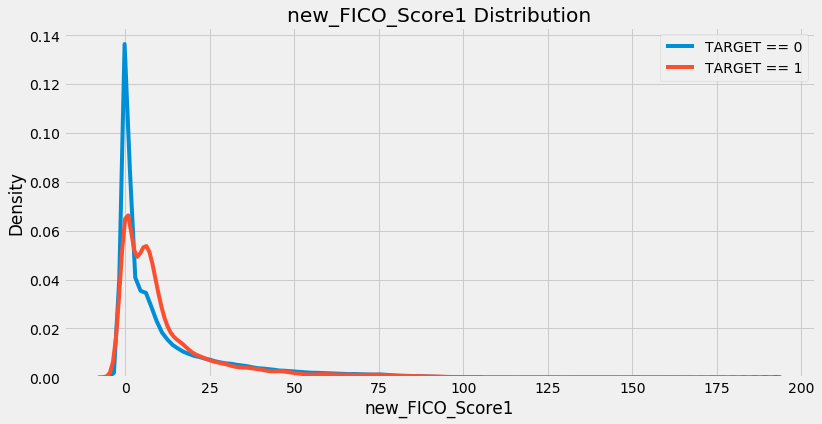

In [121]:
kde_target(df=train_prev,var_name='new_FICO_Score1')

Text(0.5,0,'NEW_CAR_TO_EMPLOY_RATIO')

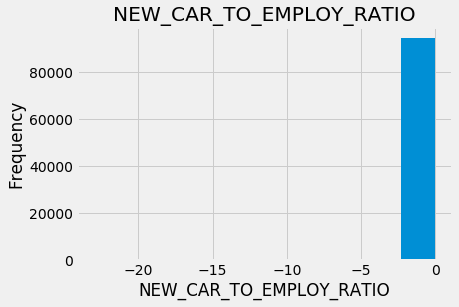

In [173]:
train['NEW_CAR_TO_EMPLOY_RATIO'].plot.hist(title = 'NEW_CAR_TO_EMPLOY_RATIO');
plt.xlabel('NEW_CAR_TO_EMPLOY_RATIO')

In [ ]:
# pointer

In [123]:
train=train.drop(columns='DAYS_LAST_PHONE_CHANGE_BINNED')
test=test.drop(columns='DAYS_LAST_PHONE_CHANGE_BINNED')

In [128]:
train_orig=train['DAYS_LAST_PHONE_CHANGE']
test_orig=test['DAYS_LAST_PHONE_CHANGE']

In [125]:
train['DAYS_LAST_PHONE_CHANGE']=train_orig
test['DAYS_LAST_PHONE_CHANGE']=test_orig

The correlation between DAYS_LAST_PHONE_CHANGE_BINNED and the TARGET is 0.0515
Median value for loan that was not repaid = 2.0000
Median value for loan that was repaid =     2.0000


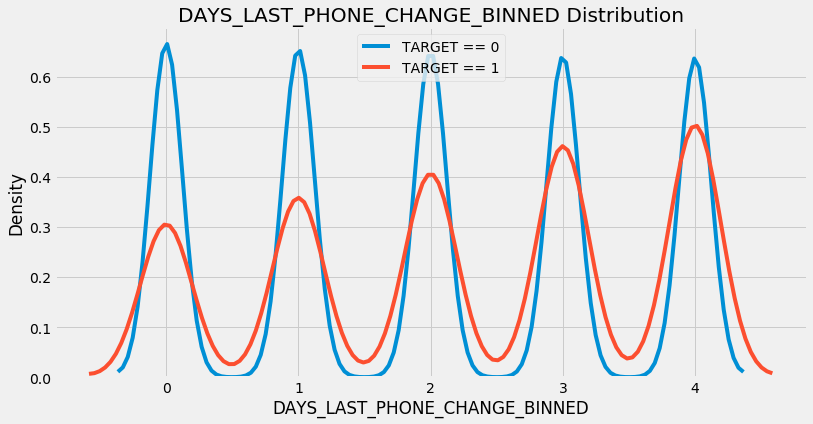

In [121]:
train['DAYS_LAST_PHONE_CHANGE']=train_orig
test['DAYS_LAST_PHONE_CHANGE']=test_orig
train['DAYS_LAST_PHONE_CHANGE_BINNED'] = pd.qcut(train.DAYS_ID_PUBLISH, q=5, labels=False)
test['DAYS_LAST_PHONE_CHANGE_BINNED'] = pd.qcut(test.DAYS_ID_PUBLISH, q=5, labels=False)
train=train.drop(columns='DAYS_LAST_PHONE_CHANGE')
test=test.drop(columns='DAYS_LAST_PHONE_CHANGE')
kde_target(df=train,var_name='DAYS_LAST_PHONE_CHANGE_BINNED')

In [122]:
train.groupby('DAYS_LAST_PHONE_CHANGE_BINNED').sum()

,TARGET,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,OWN_CAR_AGE,FLAG_EMP_PHONE,REGION_RATING_CLIENT,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,NONLIVINGAREA_AVG,FLAG_DOCUMENT_3,NEW_CREDIT_TO_ANNUITY_RATIO,NEW_CREDIT_TO_GOODS_RATIO,NEW_SOURCES_PROD,NEW_SCORES_STD,NEW_CAR_TO_EMPLOY_RATIO,NEW_PHONE_TO_EMPLOY_RATIO,SK_ID_CURR,DAYS_ID_PUBLISH
DAYS_LAST_PHONE_CHANGE_BINNED,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3731,33690605782.500,-1082945335,-115369798.000,-329197506.000,246004.000,42585,127067,3110,10994,13905.071,32343.636,27742.062,3586.402,2302.505,31294.010,4665.530,7124.181,787.541,41810,1340685.597,69056.685,3556.064,9280.870,-222.083,-inf,17134789190,-295644771
1,4363,32862294265.500,-1079425429,-109780543.000,-346540212.000,237735.000,41613,125462,3295,10804,12521.704,32081.451,27020.597,3731.300,2397.753,31829.219,4843.562,7266.951,808.679,41267,1356634.055,68866.833,3145.043,9271.405,-228.507,47952.241,17076878492,-256163253
2,4967,33276620934.000,-964435341,-127363720.000,-295711985.042,259502.000,52738,126546,5067,14862,13555.992,31680.380,25713.703,3550.808,2243.463,30381.810,4505.326,6964.520,768.398,44722,1325740.569,69086.372,3215.980,9369.338,-301.975,60115.728,17122624389,-200177897
3,5618,32624873748.000,-908733701,-123063936.000,-282496582.000,255508.000,56832,125973,6288,16933,13483.288,31035.333,23666.725,3426.610,2150.350,29921.043,4368.185,6752.424,772.160,45784,1304705.605,68925.347,2965.324,9339.034,-348.296,61050.206,17127096690,-125180477
4,6146,32956999767.000,-895958339,-125542942.000,-279324016.000,262603.000,58353,126098,6279,17274,13885.064,30698.783,21804.445,3491.123,2188.097,30568.124,4477.533,6850.150,771.737,44757,1317605.840,69080.137,2823.178,9248.155,-373.473,59668.695,17081378141,-43571575


In [ ]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

# Variance Inflation Factor (VIF) Explained

In [ ]:
train_numerical=train._get_numeric_data()

In [ ]:
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(train_numerical)
train_numerical = imputer.transform(train_numerical)
#test[min_max_columns] = imputer.transform(test[min_max_columns])

In [ ]:
#Imports
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from subprocess import check_output

# Any results you write to the current directory are saved as output.

# Extra imports necessary for the code
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer

X = train.copy()
y = X.pop('TARGET')
X = pd.get_dummies(X)
X.head()

In [ ]:
class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = Imputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [ ]:
transformer = ReduceVIF()

# Only use 10 columns for speed in this example
X = transformer.fit_transform(X.columns, y)

X.head()

In [ ]:
#Step 3: Inspect VIF Factors
vif.round(1)

In [ ]:
plt.figure(figsize = (10, 12))
plt.style.use('fivethirtyeight')
# iterate through the sources
for i, source in enumerate(feature_drop_column):
    try:
        corr = train['TARGET'].corr(train[source])
    except:
        print('string')
    print(source,corr)
    #kde_target(df=train,var_name=source)
    # create a new subplot for each source
   # plt.subplot(3, 1, i + 1)
    # plot repaid loans
    #sns.kdeplot(train.loc[train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
   # sns.kdeplot(train.loc[train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
   # plt.title('Distribution of %s by Target Value' % source)
   # plt.xlabel('%s' % source); plt.ylabel('Density');
    
#plt.tight_layout(h_pad = 2.5)

## Model performace test with application data only
## Test1

In [ ]:
train.dtypes.value_counts()

In [ ]:
gc.enable()
del train, test
gc.collect()

In [ ]:
train=pd.read_csv('./train_intro_raw.csv')
test=pd.read_csv('./test_intro_raw.csv')

In [ ]:
train.dtypes.value_counts()

In [363]:
train['SK_ID_CURR']=train_sk_id_curr
test['SK_ID_CURR']=test_sk_id_curr

In [108]:
train.to_csv('./temp1.csv',index=False)
test.to_csv('./temp2.csv', index=False)
train=pd.read_csv('./temp1.csv')
test=pd.read_csv('./temp2.csv')


In [119]:
test.shape

(1739, 28)

In [374]:
train_prev['SK_ID_CURR']=train_sk_id_curr
test_prev['SK_ID_CURR']=test_sk_id_curr

In [197]:
# f11

In [117]:
submission, feature_importances, metrics = model(train_prev, test_prev)

Training Data Shape:  (307511, 226)
Testing Data Shape:  (48744, 226)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.773794	valid's binary_logloss: 0.549108	train's auc: 0.814416	train's binary_logloss: 0.538016
Early stopping, best iteration is:
[292]	valid's auc: 0.775233	valid's binary_logloss: 0.537631	train's auc: 0.830753	train's binary_logloss: 0.52195
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.776807	valid's binary_logloss: 0.551048	train's auc: 0.814195	train's binary_logloss: 0.538098
[400]	valid's auc: 0.778664	valid's binary_logloss: 0.529241	train's auc: 0.847193	train's binary_logloss: 0.506013
Early stopping, best iteration is:
[489]	valid's auc: 0.778863	valid's binary_logloss: 0.52056	train's auc: 0.859443	train's binary_logloss: 0.493102
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.765961	valid's binary_logloss: 0.549096	train's auc: 0.815806	train's bi

In [247]:
submission.to_csv('submission_21102018.csv',index=False)

In [118]:
#with prev app, withou catg
metrics

,fold,train,valid
0,0,0.831,0.775
1,1,0.859,0.779
2,2,0.843,0.767
3,3,0.846,0.775
4,4,0.837,0.780
5,overall,0.843,0.775


In [246]:
#with with binned AMT_GOODS_PRICE_BINNED
metrics

,fold,train,valid
0,0,0.853,0.777
1,1,0.887,0.782
2,2,0.866,0.771
3,3,0.841,0.778
4,4,0.879,0.781
5,overall,0.865,0.777


In [108]:
#with prev applicatn data only
metrics

,fold,train,valid
0,0,0.846,0.773
1,1,0.856,0.778
2,2,0.853,0.767
3,3,0.830,0.773
4,4,0.845,0.779
5,overall,0.846,0.774


In [181]:
#with applicatn data only
metrics

,fold,train,valid
0,0,0.815,0.766
1,1,0.818,0.769
2,2,0.827,0.759
3,3,0.814,0.767
4,4,0.838,0.771
5,overall,0.822,0.766


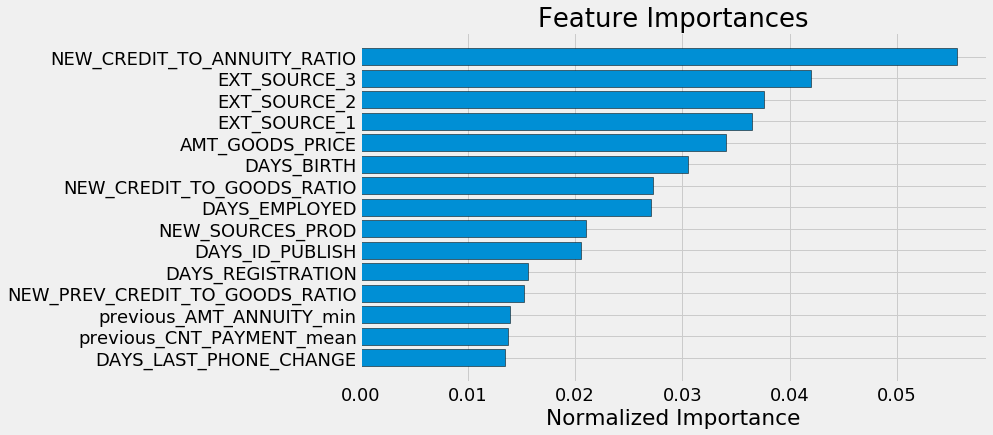

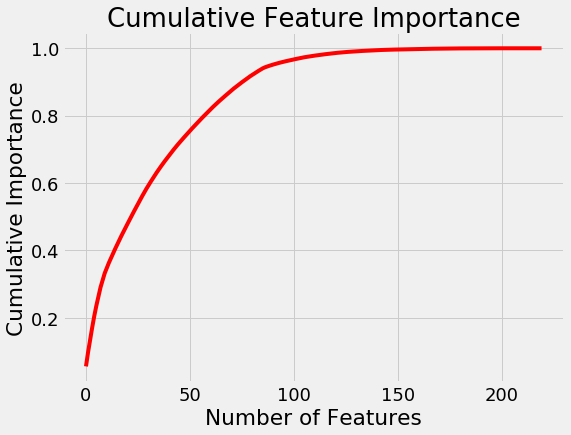

91 features required for 0.95 of cumulative importance


In [238]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

In [239]:
norm_feature_importances[norm_feature_importances['cumulative_importance']>0.95]['feature']

90                   OCCUPATION_TYPE_Core staff
91                                CODE_GENDER_M
92               previous_AMT_GOODS_PRICE_count
93              previous_AMT_DOWN_PAYMENT_count
94              ORGANIZATION_TYPE_Self-employed
95                     NAME_INCOME_TYPE_Working
96               NAME_INCOME_TYPE_State servant
97                   ORGANIZATION_TYPE_Military
98           ORGANIZATION_TYPE_Industry: type 9
99                      OCCUPATION_TYPE_Drivers
100         previous_NFLAG_LAST_APPL_IN_DAY_sum
101              ORGANIZATION_TYPE_Construction
102                  previous_AMT_ANNUITY_count
103      previous_NFLAG_INSURED_ON_APPROVAL_sum
104           previous_DAYS_FIRST_DRAWING_count
105    ORGANIZATION_TYPE_Business Entity Type 3
106              OCCUPATION_TYPE_Medicine staff
107         ORGANIZATION_TYPE_Transport: type 3
108                    ORGANIZATION_TYPE_School
109                 OCCUPATION_TYPE_Accountants
110                    OCCUPATION_TYPE_L

<br><br>
# ----------------------------------------------------------------
<br><br>